# Setup and Data Import

### Goals:

* Clean up the Medicare  

### Outputs:

* /data/tidy_data/med_partD_benzo_indiv_pres_w_town_merge.csv

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
sns.set_style('darkgrid')

In [8]:
# cms opioid prescriber data
opi_pres_sum_13_raw = pd.read_csv("../../data/raw_data/Medicare_Part_D_Opioid_Prescriber_Summary_File_2013.csv")
opi_pres_sum_14_raw = pd.read_csv("../../data/raw_data/Medicare_Part_D_Opioid_Prescriber_Summary_File_2014.csv")
opi_pres_sum_15_raw = pd.read_csv("../../data/raw_data/Medicare_Part_D_Opioid_Prescriber_Summary_File_2015.csv")
opi_pres_sum_16_raw = pd.read_csv("../../data/raw_data/Medicare_Part_D_Opioid_Prescriber_Summary_File_2016.csv")
opi_pres_sum_17_raw = pd.read_csv("../../data/raw_data/Medicare_Part_D_Opioid_Prescriber_Summary_File_2017.csv")

In [9]:
# cms non-opioid prescriber data (big)
cms_all_pres_raw = pd.read_csv("../../data/raw_data/medicare_prescription_all_drugs/PartD_Prescriber_PUF_NPI_Drug_17.txt", sep='\t')

In [10]:
# zipcode - town association attempts
## zipcode - town lists (copy paste from websites)
zip_town_raw = pd.read_csv('../../data/raw_data/ma_town_zipcode_list.txt', sep="(", header=None)
zip_town_raw_alt = pd.read_csv('../../data/raw_data/ma_town_zipcode_list_alt.txt', sep='\t')
## shapfile of ma postal zipcodes
ma_postzip_map = gpd.read_file('../../data/raw_data/zipcodes_nt/ZIPCODES_NT_POLY.shp')
# compare zipcodes and town names to the overdose deaths dataset (351 towns)
ma_over_death = pd.read_csv("../../data/tidy_data/ma_town_opioid_overdose_death_by_place_of_death_2014_to_2018.csv")

In [11]:
# easier column names for opi prescriber dfs
lwr_column_names =[x.lower().replace(' ', '_') for x in opi_pres_sum_13_raw.columns]
raw_opi_dflist = [opi_pres_sum_13_raw, opi_pres_sum_14_raw, opi_pres_sum_15_raw, opi_pres_sum_16_raw, opi_pres_sum_17_raw]
for x in raw_opi_dflist:
    x.columns = lwr_column_names

In [12]:
opi_pres_sum_17_raw.head()

,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,nppes_provider_state,specialty_description,total_claim_count,opioid_claim_count,opioid_prescribing_rate,long-acting_opioid_claim_count,long-acting_opioid_prescribing_rate
0,1003000126,ENKESHAFI,ARDALAN,21502.0,MD,Internal Medicine,677,25.0,3.69,NaN,NaN
1,1003000142,KHALIL,RASHID,43623.0,OH,Anesthesiology,1946,1040.0,53.44,200.0,19.23
2,1003000167,ESCOBAR,JULIO,89403.0,NV,Dentist,55,14.0,25.45,0.0,0.00
3,1003000175,REYES-VASQUEZ,BELINDA,91744.0,CA,Dentist,18,0.0,0.00,0.0,NaN
4,1003000282,BLAKEMORE,ROSIE,37243.0,TN,Nurse Practitioner,90,0.0,0.00,0.0,NaN


In [13]:
opi_pres_17_MA = opi_pres_sum_17_raw[opi_pres_sum_17_raw['nppes_provider_state'] == 'MA'].copy()

In [14]:
opi_pres_17_MA.head()

,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,nppes_provider_state,specialty_description,total_claim_count,opioid_claim_count,opioid_prescribing_rate,long-acting_opioid_claim_count,long-acting_opioid_prescribing_rate
36,1003002312,HOPKINS,PATRICIA,2169.0,MA,Rheumatology,4487,513.0,11.43,84.0,16.37
118,1003007477,ABDOW,KIMBERLY,1609.0,MA,Nurse Practitioner,5314,0.0,0.00,0.0,NaN
132,1003008244,RAJBHANDARI,RUMA,2115.0,MA,Gastroenterology,56,0.0,0.00,0.0,NaN
189,1003011610,RAY,ALAKA,2114.0,MA,Internal Medicine,1993,62.0,3.11,NaN,NaN
224,1003012766,KANO,ZACHARY,2445.0,MA,Dentist,19,0.0,0.00,0.0,NaN


In [15]:
all_pres_17_MA = cms_all_pres_raw[cms_all_pres_raw['nppes_provider_state'] == 'MA'].copy()
all_pres_17_MA_prov = all_pres_17_MA.iloc[:, 0:6].copy().drop_duplicates()
display(all_pres_17_MA_prov.head())

,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_city,nppes_provider_state,specialty_description
757,1003002312,HOPKINS,PATRICIA,QUINCY,MA,Rheumatology
2478,1003007477,ABDOW,KIMBERLY,WORCESTER,MA,Nurse Practitioner
2997,1003008244,RAJBHANDARI,RUMA,BOSTON,MA,Gastroenterology
4569,1003011610,RAY,ALAKA,BOSTON,MA,Internal Medicine
5158,1003012766,KANO,ZACHARY,BROOKLINE,MA,Dentist


In [16]:
# sanity check
print(len(set(opi_pres_17_MA['npi']) - set(all_pres_17_MA['npi'])))
print(len(set(all_pres_17_MA['npi']) - set(opi_pres_17_MA['npi'])))
print(len(set(opi_pres_17_MA['npi']) - set(cms_all_pres_raw['npi'])))
print(len(set(all_pres_17_MA['npi'])))
print(len(set(opi_pres_17_MA['npi'])))

8430
0
8430
27300
35730


In [17]:
all_pres_17_MA_prov.shape

(27300, 6)

In [18]:
opi_pres_17_MA['nppes_provider_zip_code'] = [x.zfill(5) for x in list(opi_pres_17_MA['nppes_provider_zip_code'].astype(int).astype(str))]

In [19]:
all_pres_17_MA.columns

Index(['npi', 'nppes_provider_last_org_name', 'nppes_provider_first_name',
       'nppes_provider_city', 'nppes_provider_state', 'specialty_description',
       'description_flag', 'drug_name', 'generic_name', 'bene_count',
       'total_claim_count', 'total_30_day_fill_count', 'total_day_supply',
       'total_drug_cost', 'bene_count_ge65', 'bene_count_ge65_suppress_flag',
       'total_claim_count_ge65', 'ge65_suppress_flag',
       'total_30_day_fill_count_ge65', 'total_day_supply_ge65',
       'total_drug_cost_ge65'],
      dtype='object')

In [20]:
opi_pres_MA_miss = opi_pres_17_MA[~ opi_pres_17_MA['npi'].isin(set(all_pres_17_MA['npi']))].copy()

In [21]:
opi_pres_MA_miss.columns

Index(['npi', 'nppes_provider_last_name', 'nppes_provider_first_name',
       'nppes_provider_zip_code', 'nppes_provider_state',
       'specialty_description', 'total_claim_count', 'opioid_claim_count',
       'opioid_prescribing_rate', 'long-acting_opioid_claim_count',
       'long-acting_opioid_prescribing_rate'],
      dtype='object')

In [22]:
opi_pres_MA_miss['specialty_description'].value_counts()

Internal Medicine                                                 1355
Nurse Practitioner                                                1011
Dentist                                                            890
Student in an Organized Health Care Education/Training Program     890
Physician Assistant                                                550
                                                                  ... 
Physical Therapist in Private Practice                               1
Social Worker                                                        1
Interventional Cardiology                                            1
Assistant, Podiatric                                                 1
Sleep Medicine                                                       1
Name: specialty_description, Length: 97, dtype: int64

In [23]:
all_pres_17_MA['specialty_description'].value_counts()

Internal Medicine                                     242242
Nurse Practitioner                                     85862
Family Practice                                        83128
Psychiatry                                             26665
Physician Assistant                                    26472
                                                       ...  
Assistant, Podiatric                                       1
Thoracic Surgery (Cardiothoracic Vascular Surgery)         1
Midwife                                                    1
Hospital                                                   1
Registered Dietitian or Nutrition Professional             1
Name: specialty_description, Length: 96, dtype: int64

In [24]:
opi_pres_17_MA.head()

,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,nppes_provider_state,specialty_description,total_claim_count,opioid_claim_count,opioid_prescribing_rate,long-acting_opioid_claim_count,long-acting_opioid_prescribing_rate
36,1003002312,HOPKINS,PATRICIA,02169,MA,Rheumatology,4487,513.0,11.43,84.0,16.37
118,1003007477,ABDOW,KIMBERLY,01609,MA,Nurse Practitioner,5314,0.0,0.00,0.0,NaN
132,1003008244,RAJBHANDARI,RUMA,02115,MA,Gastroenterology,56,0.0,0.00,0.0,NaN
189,1003011610,RAY,ALAKA,02114,MA,Internal Medicine,1993,62.0,3.11,NaN,NaN
224,1003012766,KANO,ZACHARY,02445,MA,Dentist,19,0.0,0.00,0.0,NaN


In [25]:
print(opi_pres_17_MA.shape)
print(all_pres_17_MA_prov.shape)

(35730, 11)
(27300, 6)


In [26]:
# give the all drug prescribers zipcodes
all_pres_17_MA_prov = all_pres_17_MA_prov.merge(opi_pres_17_MA[['npi', 'nppes_provider_zip_code']], on='npi', how='left')

In [27]:
all_pres_17_MA_prov.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27300 entries, 0 to 27299
Data columns (total 7 columns):
npi                             27300 non-null int64
nppes_provider_last_org_name    27299 non-null object
nppes_provider_first_name       27300 non-null object
nppes_provider_city             27300 non-null object
nppes_provider_state            27300 non-null object
specialty_description           27300 non-null object
nppes_provider_zip_code         27300 non-null object
dtypes: int64(1), object(6)
memory usage: 1.7+ MB


In [28]:
len(set(all_pres_17_MA_prov['nppes_provider_city']))

456

In [29]:
set(all_pres_17_MA_prov['nppes_provider_city'].str.lower()) - set(ma_over_death['city_death'])

{'allston',
 'ann arbor',
 'ashburham',
 'assonet',
 'attleboro falls',
 'auburndale',
 'baldwinville',
 'beford',
 'beverly farms',
 'boston, ma',
 'bradford',
 'brighton',
 'brighton, ma',
 'brochton',
 'brocktom',
 'buzzards bay',
 'byfield',
 'cambirdge',
 'centerville',
 'charlestown',
 'chestnut hill',
 'cotuit',
 'dennis port',
 'dorchester',
 'dorchester center',
 'e bridgewater',
 'e falmouth',
 'e longmeadow',
 'e sandwich',
 'e. wareham',
 'e. weymouth',
 'east boston',
 'east cambridge',
 'east dennis',
 'east douglas',
 'east falmouth',
 'east freetown',
 'east lynn',
 'east orleans',
 'east sandwich',
 'east walpole',
 'east wareham',
 'east weymouth',
 'everette',
 'feeding hills',
 'flint',
 'florence',
 'forestdale',
 'foxboro',
 'fram',
 'fromingham',
 'gand rapids',
 'gt barrington',
 'hanscom afb',
 'hanscon afb',
 'harwich port',
 'hathorne',
 'haverhilll',
 'haydenville',
 'hyannis',
 'hyde park',
 'indian orchard',
 'jamaica plain',
 'lanesboro',
 'laurence',
 'l

In [30]:
zip_town_raw.head()

,0,1
0,02351 Abington,781)
1,02018 Accord,781)
2,01718 Acton,978)
3,01719 Acton,978)
4,01720 Acton,978)


In [31]:
zip_town = zip_town_raw.iloc[:, [0]].copy()
zip_town.columns = ['col1']
zip_town['zip'] = [x[:5] for x in zip_town['col1']]
zip_town.head()

,col1,zip
0,02351 Abington,02351
1,02018 Accord,02018
2,01718 Acton,01718
3,01719 Acton,01719
4,01720 Acton,01720


In [32]:
zip_town['town'] = [x[6:] for x in zip_town['col1']]
# towns have white spaces at the end (carryover from formatting)
zip_town['town'] = zip_town['town'].str.strip().str.lower()
zip_town.drop('col1', axis=1, inplace=True)
zip_town.head()

,zip,town
0,02351,abington
1,02018,accord
2,01718,acton
3,01719,acton
4,01720,acton


In [33]:
ma_over_death.head()

,city_death,2014,2015,2016,2017,2018
0,abington,0,6,1,3,5
1,acton,1,2,3,0,1
2,acushnet,0,4,2,4,0
3,adams,2,3,1,0,4
4,agawam,1,2,0,4,8


In [34]:
print(len(set(zip_town['town'])))
print(len(set(ma_over_death['city_death'])))

806
351


In [35]:
np.unique(zip_town['town'])
# town names are too granular, try another source

array(['abington', 'accord', 'acton', 'acushnet', 'adams',
       'aetna life & casualty co', 'agawam', 'alford', 'allendale',
       'allmerica', 'allston', 'amesbury', 'amherst', 'andover',
       'aquinnah', 'arlington', 'arlington heights', 'ashburnham',
       'ashby', 'ashfield', 'ashland', 'ashley falls', 'assinippi',
       'assonet', 'athol', 'attleboro', 'attleboro falls', 'auburn',
       'auburndale', 'avon', 'ayer', 'babson park', 'baldwinville',
       'bank of america', 'baptist corner', 'barnstable', 'barre',
       'bass river', 'bay state village', 'bay state west tower',
       'baystate medical', 'beachmont', 'becket', 'becket corners',
       'bedford', 'belchertown', 'bellingham', 'belmont', 'berkley',
       'berkshire', 'berkshire heights', 'berlin', 'bernardston',
       'beverly', 'beverly farms', 'big pond', 'billerica', 'blackstone',
       'blandford', 'blissville', 'bolton', 'bondsville', 'boston',
       'boston city hall', 'boston college',
       'bosto

In [36]:
zip_town_raw_alt.head()

,ZIP Code,City,County,Type
0,ZIP Code 01001,Agawam,Hampden,Standard
1,ZIP Code 01002,Amherst,Hampshire,Standard
2,ZIP Code 01003,Amherst,Hampshire,Standard
3,ZIP Code 01004,Amherst,Hampshire,P.O. Box
4,ZIP Code 01005,Barre,Worcester,Standard


In [37]:
zip_town_raw_alt.columns = [x.lower().strip() for x in list(zip_town_raw_alt.columns)]

In [38]:
len(np.unique(zip_town_raw_alt['city']))

512

In [39]:
zip_town_raw_alt['type'].value_counts()

Standard    492
P.O. Box    156
Unique       34
Name: type, dtype: int64

In [40]:
zip_stand = zip_town_raw_alt[zip_town_raw_alt['type'] == 'Standard'].copy()
print(len(set(zip_stand['city'])))
# closer count - try matching what's missing
zip_stand['city'] = zip_stand['city'].str.lower()
zip_stand.head()

417


,zip code,city,county,type
0,ZIP Code 01001,agawam,Hampden,Standard
1,ZIP Code 01002,amherst,Hampshire,Standard
2,ZIP Code 01003,amherst,Hampshire,Standard
4,ZIP Code 01005,barre,Worcester,Standard
5,ZIP Code 01007,belchertown,Hampshire,Standard


In [41]:
# mismatches
print(len(set(ma_over_death['city_death']) - set(zip_stand['city'])))
print(len(set(zip_stand['city']) - set(ma_over_death['city_death'])))
# maybe there's a better source

40
106


In [42]:
ma_postzip_map.head()

,POSTCODE,PC_NAME,PC_TYPE,PA_NAME,PA_FIPS,CITY_TOWN,COUNTY,AREA_SQMI,SHAPE_AREA,SHAPE_LEN,geometry
0,01331,ATHOL,NON UNIQUE,ATHOL,02515,"ATHOL, TOWN OF",WORCESTER,58.084870,1.504391e+08,66459.581259,"POLYGON ((147583.6014999971 930766.1334999986,..."
1,01085,WESTFIELD,NON UNIQUE,WESTFIELD,76030,WESTFIELD,HAMPDEN,55.938928,1.448812e+08,61329.577100,"POLYGON ((101952.2437999994 882113.238499999, ..."
2,01370,SHELBURNE FALLS,NON UNIQUE,SHELBURNE FALLS,61205,"SHELBURNE, TOWN OF",FRANKLIN,48.804057,1.264019e+08,70885.011312,"POLYGON ((107090.9670000002 933358.561999999, ..."
3,01235,HINSDALE,NON UNIQUE,HINSDALE,30280,"HINSDALE, TOWN OF",BERKSHIRE,47.757052,1.236902e+08,49286.404925,"POLYGON ((77728.64249999821 914027.9114000015,..."
4,02747,NORTH DARTMOUTH,NON UNIQUE,NORTH DARTMOUTH,47450,"DARTMOUTH, TOWN OF",BRISTOL,47.495414,1.230126e+08,66614.835420,"POLYGON ((242894.990199998 830521.8995000012, ..."


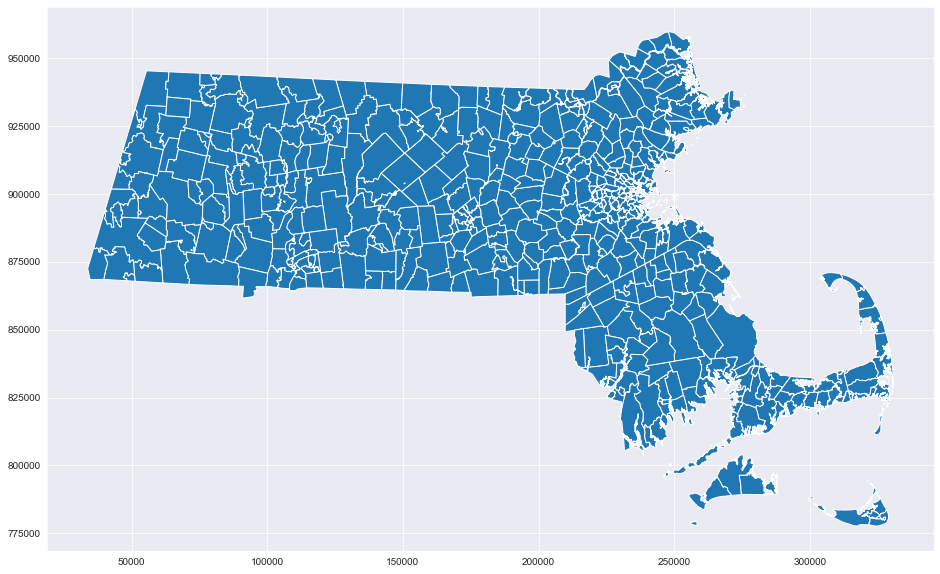

In [43]:
ma_postzip_map.plot(figsize=(16,10))

In [44]:
print(len(set(ma_postzip_map['CITY_TOWN'])))
print(len(set(ma_postzip_map['PC_NAME'])))

335
458


In [45]:
set(ma_postzip_map['CITY_TOWN'].str.lower().str.replace(', town of', '')) - set(ma_over_death['city_death'])

{'manchester by the sea', 'mt washington', 'north attleborough'}

In [46]:
set(ma_over_death['city_death']) - set(ma_postzip_map['CITY_TOWN'].str.lower().str.replace(', town of', ''))

{'alford',
 'aquinnah',
 'clarksburg',
 'egremont',
 'granville',
 'hawley',
 'leyden',
 'manchester',
 'montgomery',
 'mount washington',
 'new ashford',
 'north attleboro',
 'pelham',
 'peru',
 'phillipston',
 'tisbury',
 'washington',
 'west tisbury',
 'westhampton'}

In [47]:
ma_over_death['city_death_match'] = ma_over_death['city_death'].str.replace('manchester', 'manchester by the sea').str.replace('mount washington', 'mt washington').str.replace('north attleboro', 'north attleborough')

In [48]:
# death counts for towns/cities I'm missing
ma_over_death[ma_over_death['city_death_match'].isin(set(ma_over_death['city_death_match']) - set(ma_postzip_map['CITY_TOWN'].str.lower().str.replace(', town of', '')))]

,city_death,2014,2015,2016,2017,2018,city_death_match
5,alford,0,0,0,0,0,alford
9,aquinnah,0,0,0,0,0,aquinnah
63,clarksburg,0,0,0,1,0,clarksburg
90,egremont,0,0,0,0,0,egremont
111,granville,0,0,0,0,0,granville
128,hawley,0,0,0,0,0,hawley
155,leyden,0,0,0,0,0,leyden
193,montgomery,0,0,0,0,0,montgomery
199,new ashford,0,0,0,0,0,new ashford
229,pelham,0,0,0,0,0,pelham


In [49]:
zip_miss = set(opi_pres_17_MA['nppes_provider_zip_code']) - set(ma_postzip_map['POSTCODE'])

In [50]:
opi_pres_17_MA[opi_pres_17_MA['nppes_provider_zip_code'].isin(zip_miss)]

,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,nppes_provider_state,specialty_description,total_claim_count,opioid_claim_count,opioid_prescribing_rate,long-acting_opioid_claim_count,long-acting_opioid_prescribing_rate
303,1003015686,BLUME,DEBORAH,01199,MA,Physician Assistant,1562,28.0,1.79,0.0,0.0
769,1003041971,IRONS,HILLARY,01655,MA,Emergency Medicine,53,NaN,NaN,0.0,NaN
1516,1003080151,NICORA,AGNIESZKA,01199,MA,Emergency Medicine,216,NaN,NaN,0.0,NaN
1662,1003090143,DUBIN,JOSEPH,01805,MA,Internal Medicine,139,NaN,NaN,0.0,NaN
1995,1003108259,KORAPATI,SOWMYA,01655,MA,Hematology-Oncology,15,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1159959,1992854707,ABRAMOV,KONSTANTIN,01655,MA,Nephrology,1519,27.0,1.78,NaN,NaN
1160834,1992891352,DEPETERS,FRANKLIN,01655,MA,Diagnostic Radiology,68,0.0,0.00,0.0,NaN
1161153,1992902977,CROWLEY,JILLIAN,01199,MA,Physician Assistant,107,18.0,16.82,0.0,0.0
1162263,1992964183,MACLACHLAN,LARA,01805,MA,Urology,1487,NaN,NaN,0.0,NaN


In [51]:
postzip_town_match = ma_postzip_map.iloc[:, 0:7]
postzip_town_match.head()
print(sum(postzip_town_match['PC_NAME'] != postzip_town_match['PA_NAME']))
display(postzip_town_match[postzip_town_match['PC_NAME'] != postzip_town_match['PA_NAME']])
postzip_town_match = postzip_town_match.apply(lambda x: x.str.lower())
postzip_town_match['CITY_TOWN'] = postzip_town_match['CITY_TOWN'].str.replace(', town of', '')
postzip_town_match.head()

3


,POSTCODE,PC_NAME,PC_TYPE,PA_NAME,PA_FIPS,CITY_TOWN,COUNTY
497,01441,TYCO,UNIQUE ORGANIZATION,WESTMINSTER,76975,"WESTMINSTER, TOWN OF",WORCESTER
520,02357,STONEHILL COLLEGE,UNIQUE ORGANIZATION,NORTH EASTON,47625,"EASTON, TOWN OF",BRISTOL
530,01063,SMITH COLLEGE,UNIQUE ORGANIZATION,NORTHAMPTON,46330,NORTHAMPTON,HAMPSHIRE


,POSTCODE,PC_NAME,PC_TYPE,PA_NAME,PA_FIPS,CITY_TOWN,COUNTY
0,01331,athol,non unique,athol,02515,athol,worcester
1,01085,westfield,non unique,westfield,76030,westfield,hampden
2,01370,shelburne falls,non unique,shelburne falls,61205,shelburne,franklin
3,01235,hinsdale,non unique,hinsdale,30280,hinsdale,berkshire
4,02747,north dartmouth,non unique,north dartmouth,47450,dartmouth,bristol


In [52]:
print(set(ma_over_death['city_death_match']) - set(postzip_town_match['CITY_TOWN']))
print(set(postzip_town_match['CITY_TOWN']) - set(ma_over_death['city_death_match']))

{'alford', 'egremont', 'westhampton', 'montgomery', 'west tisbury', 'peru', 'tisbury', 'leyden', 'new ashford', 'clarksburg', 'washington', 'granville', 'hawley', 'aquinnah', 'pelham', 'phillipston'}
set()


In [53]:
len(zip_miss)

74

In [54]:
zip_town_raw_alt.head()

,zip code,city,county,type
0,ZIP Code 01001,Agawam,Hampden,Standard
1,ZIP Code 01002,Amherst,Hampshire,Standard
2,ZIP Code 01003,Amherst,Hampshire,Standard
3,ZIP Code 01004,Amherst,Hampshire,P.O. Box
4,ZIP Code 01005,Barre,Worcester,Standard


In [55]:
zip_town.head()

,zip,town
0,02351,abington
1,02018,accord
2,01718,acton
3,01719,acton
4,01720,acton


In [56]:
print(set(ma_over_death['city_death_match']) - set(zip_town['town']))
print(set(ma_over_death['city_death_match']) - set(zip_town_raw_alt['city'].str.lower()))
#zip_town will get me more towns

{'freetown', 'gosnold', 'yarmouth', 'north attleborough'}
{'hancock', 'florida', 'new marlborough', 'middleborough', 'new ashford', 'yarmouth', 'hawley', 'egremont', 'freetown', 'montgomery', 'foxborough', 'washington', 'phillipston', 'shelburne', 'manchester by the sea', 'alford', 'north attleborough', 'monroe', 'peru', 'tisbury', 'leyden', 'tolland', 'mt washington', 'aquinnah', 'pelham', 'westhampton', 'clarksburg', 'bourne', 'tyngsborough', 'gosnold'}


In [57]:
print(len(zip_miss))
print(len(zip_town[zip_town['zip'].isin(zip_miss)]))

74
36


In [58]:
zip_fill = zip_town[zip_town['zip'].isin(zip_miss) & zip_town['town'].isin(set(ma_over_death['city_death']))]
zip_fill

,zip,town
88,02117,boston
111,02199,boston
118,02211,boston
124,02241,boston
143,02185,braintree
148,02325,bridgewater
167,01805,burlington
177,02238,cambridge
298,02334,easton
309,02722,fall river


In [59]:
zip_town_fin = postzip_town_match[['POSTCODE', 'CITY_TOWN']]
zip_town_fin.columns = list(zip_fill.columns)
zip_town_fin = pd.concat([zip_town_fin, zip_fill]).reindex()
print(zip_town_fin.shape)
print(zip_town_fin.drop_duplicates().shape)
zip_town_fin.head()

(572, 2)
(572, 2)


,zip,town
0,01331,athol
1,01085,westfield
2,01370,shelburne
3,01235,hinsdale
4,02747,dartmouth


In [60]:
print(set(ma_over_death['city_death_match']) - set(zip_town_fin['town']))
print(set(zip_town_fin['town']) - set(ma_over_death['city_death_match']))

{'alford', 'egremont', 'westhampton', 'montgomery', 'peru', 'new ashford', 'leyden', 'clarksburg', 'washington', 'granville', 'hawley', 'aquinnah', 'pelham', 'phillipston'}
set()


In [61]:
#pd.DataFrame(list(zip_miss - set(zip_fill['zip']))).to_csv('missing_zipcodes.csv')

In [62]:
zip_miss_town = zip_town[zip_town['zip'].isin(zip_miss) & ~zip_town['town'].isin(set(ma_over_death['city_death']))].copy()
zip_miss_town['alt_town'] = ['springfield', 'bridgewater', 'orleans',
                   'boston', 'cambridge', 'danvers',
                   'burlington', 'plymouth', 'marshfield',
                   'eastham', 'northampton', 'winchendon', 'winchendon']

In [63]:
zip_miss_town

,zip,town,alt_town
54,01199,baystate medical,springfield
149,02325,bridgewater state college,bridgewater
282,02643,east orleans,orleans
323,02241,fleet bank boston,boston
383,02238,harvard square,cambridge
391,01937,hathorne,danvers
445,01805,lahey clinic medical center,burlington
498,02345,manomet,plymouth
509,02051,marshfield hills,marshfield
651,02651,north eastham,eastham


In [64]:
set(zip_miss_town['alt_town']) - set(ma_over_death['city_death_match'])

set()

In [65]:
#zip_town_fin
zip_miss_town = zip_miss_town.drop('town', axis=1)
zip_miss_town.columns = zip_town_fin.columns

In [66]:
zip_town_fin = pd.concat([zip_town_fin, zip_miss_town]).drop_duplicates()
print(zip_town_fin.shape)
zip_town_fin.head()

(578, 2)


,zip,town
0,01331,athol
1,01085,westfield
2,01370,shelburne
3,01235,hinsdale
4,02747,dartmouth


In [67]:
print(set(zip_town_fin['town']) - set(ma_over_death['city_death_match']))
print(set(ma_over_death['city_death_match']) - set(zip_town_fin['town']))

set()
{'alford', 'egremont', 'westhampton', 'montgomery', 'peru', 'new ashford', 'leyden', 'clarksburg', 'washington', 'granville', 'hawley', 'aquinnah', 'pelham', 'phillipston'}


In [68]:
display(opi_pres_17_MA.head())
display(all_pres_17_MA_prov.head())

,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,nppes_provider_state,specialty_description,total_claim_count,opioid_claim_count,opioid_prescribing_rate,long-acting_opioid_claim_count,long-acting_opioid_prescribing_rate
36,1003002312,HOPKINS,PATRICIA,02169,MA,Rheumatology,4487,513.0,11.43,84.0,16.37
118,1003007477,ABDOW,KIMBERLY,01609,MA,Nurse Practitioner,5314,0.0,0.00,0.0,NaN
132,1003008244,RAJBHANDARI,RUMA,02115,MA,Gastroenterology,56,0.0,0.00,0.0,NaN
189,1003011610,RAY,ALAKA,02114,MA,Internal Medicine,1993,62.0,3.11,NaN,NaN
224,1003012766,KANO,ZACHARY,02445,MA,Dentist,19,0.0,0.00,0.0,NaN


,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_city,nppes_provider_state,specialty_description,nppes_provider_zip_code
0,1003002312,HOPKINS,PATRICIA,QUINCY,MA,Rheumatology,02169
1,1003007477,ABDOW,KIMBERLY,WORCESTER,MA,Nurse Practitioner,01609
2,1003008244,RAJBHANDARI,RUMA,BOSTON,MA,Gastroenterology,02115
3,1003011610,RAY,ALAKA,BOSTON,MA,Internal Medicine,02114
4,1003012766,KANO,ZACHARY,BROOKLINE,MA,Dentist,02445


In [69]:
# number of opi prescribers now missing:
print(opi_pres_17_MA[opi_pres_17_MA['nppes_provider_zip_code'].isin(set(opi_pres_17_MA['nppes_provider_zip_code']) - set(zip_town_fin['zip']))].shape)
# number of all drug prescribers now missing:
print(all_pres_17_MA_prov[all_pres_17_MA_prov['nppes_provider_zip_code'].isin(set(all_pres_17_MA_prov['nppes_provider_zip_code']) - set(zip_town_fin['zip']))].shape)

(52, 11)
(41, 7)


In [70]:
#opi_pres_17_wtown 
zip_town_counts = zip_town_fin['zip'].value_counts().reset_index()
zip_town_counts.columns = ['zip', 'count']
print(zip_town_counts[zip_town_counts['count'] > 1].shape)
zip_town_counts[zip_town_counts['count'] > 1]

(23, 2)


,zip,count
0,01082,3
1,02467,3
2,01002,2
3,01070,2
4,01010,2
5,01434,2
6,01050,2
7,02136,2
8,01096,2
9,01011,2


In [71]:
# number of opi prescribers w/more than 1 town association:
print(opi_pres_17_MA[opi_pres_17_MA['nppes_provider_zip_code'].isin(set(zip_town_counts[zip_town_counts['count'] > 1]['zip']))].shape)
# number of all drug prescribers w/more than 1 town association:
print(all_pres_17_MA_prov[all_pres_17_MA_prov['nppes_provider_zip_code'].isin(set(zip_town_counts[zip_town_counts['count'] > 1]['zip']))].shape)

(1156, 11)
(876, 7)


In [72]:
opi_pres_17_MA.head()
zip_town_fin.head()

,zip,town
0,01331,athol
1,01085,westfield
2,01370,shelburne
3,01235,hinsdale
4,02747,dartmouth


In [73]:
opi_pres_17_MA.head()

,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,nppes_provider_state,specialty_description,total_claim_count,opioid_claim_count,opioid_prescribing_rate,long-acting_opioid_claim_count,long-acting_opioid_prescribing_rate
36,1003002312,HOPKINS,PATRICIA,02169,MA,Rheumatology,4487,513.0,11.43,84.0,16.37
118,1003007477,ABDOW,KIMBERLY,01609,MA,Nurse Practitioner,5314,0.0,0.00,0.0,NaN
132,1003008244,RAJBHANDARI,RUMA,02115,MA,Gastroenterology,56,0.0,0.00,0.0,NaN
189,1003011610,RAY,ALAKA,02114,MA,Internal Medicine,1993,62.0,3.11,NaN,NaN
224,1003012766,KANO,ZACHARY,02445,MA,Dentist,19,0.0,0.00,0.0,NaN


In [74]:
opi_pres_17_MA['nppes_provider_last_name'] = opi_pres_17_MA['nppes_provider_last_name'].str.lower()
opi_pres_17_MA['nppes_provider_first_name'] = opi_pres_17_MA['nppes_provider_first_name'].str.lower()
opi_pres_17_MA['specialty_description'] = opi_pres_17_MA['specialty_description'].str.lower()
print(opi_pres_17_MA.shape)
opi_pres_17_town = opi_pres_17_MA.merge(zip_town_fin, how='inner', left_on='nppes_provider_zip_code', right_on='zip')
print(opi_pres_17_town.shape)
opi_pres_17_town.head()

(35730, 11)
(37069, 13)


,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,nppes_provider_state,specialty_description,total_claim_count,opioid_claim_count,opioid_prescribing_rate,long-acting_opioid_claim_count,long-acting_opioid_prescribing_rate,zip,town
0,1003002312,hopkins,patricia,02169,MA,rheumatology,4487,513.0,11.43,84.0,16.37,02169,quincy
1,1003083270,kabadi,mitesh,02169,MA,cardiology,1363,0.0,0.00,0.0,NaN,02169,quincy
2,1003291121,blair,meghan,02169,MA,nurse practitioner,905,0.0,0.00,0.0,NaN,02169,quincy
3,1003834433,nair,anil,02169,MA,neurology,1133,NaN,NaN,NaN,NaN,02169,quincy
4,1003992397,carolan,patricia,02169,MA,dentist,54,NaN,NaN,0.0,NaN,02169,quincy


In [75]:
opi_pres_17_cols = list(opi_pres_17_town.columns)
# reoder columns and drop extra zipcode col
opi_pres_17_town = opi_pres_17_town[opi_pres_17_cols[0:4] + opi_pres_17_cols[-1:] + opi_pres_17_cols[4:10]]
opi_pres_17_town.head()

,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,town,nppes_provider_state,specialty_description,total_claim_count,opioid_claim_count,opioid_prescribing_rate,long-acting_opioid_claim_count
0,1003002312,hopkins,patricia,02169,quincy,MA,rheumatology,4487,513.0,11.43,84.0
1,1003083270,kabadi,mitesh,02169,quincy,MA,cardiology,1363,0.0,0.00,0.0
2,1003291121,blair,meghan,02169,quincy,MA,nurse practitioner,905,0.0,0.00,0.0
3,1003834433,nair,anil,02169,quincy,MA,neurology,1133,NaN,NaN,NaN
4,1003992397,carolan,patricia,02169,quincy,MA,dentist,54,NaN,NaN,0.0


In [76]:
npi_town_count = opi_pres_17_town['npi'].value_counts().reset_index()
npi_town_count.columns = ['npi', 'count']
display(npi_town_count.head())
npi_town_count[npi_town_count['count'] > 1].shape

,npi,count
0,1962471714,3
1,1689687097,3
2,1679530083,3
3,1720064272,3
4,1306882410,3


(1156, 2)

Will need to deal with duplicates at some point

In [77]:
# other opioid dataset processing:
opi_pres_13_MA = opi_pres_sum_13_raw[opi_pres_sum_13_raw['nppes_provider_state'] == 'MA'].copy()
opi_pres_14_MA = opi_pres_sum_14_raw[opi_pres_sum_14_raw['nppes_provider_state'] == 'MA'].copy()
opi_pres_15_MA = opi_pres_sum_15_raw[opi_pres_sum_15_raw['nppes_provider_state'] == 'MA'].copy()
opi_pres_16_MA = opi_pres_sum_16_raw[opi_pres_sum_16_raw['nppes_provider_state'] == 'MA'].copy()

In [78]:
MA_opi_dflist = [opi_pres_13_MA, opi_pres_14_MA, opi_pres_15_MA, opi_pres_16_MA]
for x in MA_opi_dflist:
    x['nppes_provider_zip_code'] = [x.zfill(5) for x in list(x['nppes_provider_zip_code'].astype(int).astype(str))]

In [79]:
for x in MA_opi_dflist:
    x['nppes_provider_last_name'] = x['nppes_provider_last_name'].str.lower()
for x in MA_opi_dflist:
    x['nppes_provider_first_name'] = x['nppes_provider_first_name'].str.lower()
for x in MA_opi_dflist:
    x['specialty_description'] = x['specialty_description'].str.lower()

In [80]:
print(len(set(opi_pres_13_MA['nppes_provider_zip_code']) - set(zip_town_fin['zip'])))
print(len(set(opi_pres_14_MA['nppes_provider_zip_code']) - set(zip_town_fin['zip'])))
print(len(set(opi_pres_15_MA['nppes_provider_zip_code']) - set(zip_town_fin['zip'])))
print(len(set(opi_pres_16_MA['nppes_provider_zip_code']) - set(zip_town_fin['zip'])))

53
46
49
46


In [81]:
print(opi_pres_13_MA.shape)
opi_pres_13_town = opi_pres_13_MA.merge(zip_town_fin, how='inner', left_on='nppes_provider_zip_code', right_on='zip')
print(opi_pres_13_town.shape)
opi_pres_13_town.head()

(32791, 11)
(34086, 13)


,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,nppes_provider_state,specialty_description,total_claim_count,opioid_claim_count,opioid_prescribing_rate,long-acting_opioid_claim_count,long-acting_opioid_prescribing_rate,zip,town
0,1003002312,hopkins,patricia,02169,MA,internal medicine,4139,522.0,12.61,104.0,19.92,02169,quincy
1,1003083270,kabadi,mitesh,02169,MA,cardiology,40,0.0,0.00,0.0,NaN,02169,quincy
2,1003834433,nair,anil,02169,MA,neurology,1217,NaN,NaN,NaN,NaN,02169,quincy
3,1003895269,angelini,domenic,02169,MA,dentist,14,0.0,0.00,0.0,NaN,02169,quincy
4,1003992397,carolan,patricia,02169,MA,dentist,37,NaN,NaN,0.0,NaN,02169,quincy


In [82]:
print(opi_pres_14_MA.shape)
opi_pres_14_town = opi_pres_14_MA.merge(zip_town_fin, how='inner', left_on='nppes_provider_zip_code', right_on='zip')
print(opi_pres_14_town.shape)
opi_pres_14_town.head()

(33380, 11)
(34734, 13)


,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,nppes_provider_state,specialty_description,total_claim_count,opioid_claim_count,opioid_prescribing_rate,long-acting_opioid_claim_count,long-acting_opioid_prescribing_rate,zip,town
0,1003001660,newton,robert,02446,MA,urology,12,0.0,0.0,0.0,NaN,02446,brookline
1,1003841198,kaplan,mark,02446,MA,obstetrics/gynecology,76,0.0,0.0,0.0,NaN,02446,brookline
2,1003842543,"reiner,jr",marshall,02446,MA,pediatric medicine,45,NaN,NaN,0.0,NaN,02446,brookline
3,1013101740,lee,peter,02446,MA,dentist,30,0.0,0.0,0.0,NaN,02446,brookline
4,1013125731,lipetsker,nickolay,02446,MA,dentist,134,0.0,0.0,0.0,NaN,02446,brookline


In [83]:
print(opi_pres_15_MA.shape)
opi_pres_15_town = opi_pres_15_MA.merge(zip_town_fin, how='inner', left_on='nppes_provider_zip_code', right_on='zip')
print(opi_pres_15_town.shape)
opi_pres_15_town.head()

(34081, 11)
(35416, 13)


,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,nppes_provider_state,specialty_description,total_claim_count,opioid_claim_count,opioid_prescribing_rate,long-acting_opioid_claim_count,long-acting_opioid_prescribing_rate,zip,town
0,1003002312,hopkins,patricia,02169,MA,internal medicine,4183,495.0,11.83,99.0,20.0,02169,quincy
1,1003083270,kabadi,mitesh,02169,MA,cardiology,906,0.0,0.00,0.0,NaN,02169,quincy
2,1003291121,blair,meghan,02169,MA,nurse practitioner,45,0.0,0.00,0.0,NaN,02169,quincy
3,1003834433,nair,anil,02169,MA,neurology,1079,16.0,1.48,0.0,0.0,02169,quincy
4,1003895269,angelini,domenic,02169,MA,dentist,17,NaN,NaN,0.0,NaN,02169,quincy


In [84]:
print(opi_pres_16_MA.shape)
opi_pres_16_town = opi_pres_16_MA.merge(zip_town_fin, how='inner', left_on='nppes_provider_zip_code', right_on='zip')
print(opi_pres_16_town.shape)
opi_pres_16_town.head()

(35029, 11)
(36357, 13)


,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,nppes_provider_state,specialty_description,total_claim_count,opioid_claim_count,opioid_prescribing_rate,long-acting_opioid_claim_count,long-acting_opioid_prescribing_rate,zip,town
0,1003002312,hopkins,patricia,02169,MA,rheumatology,4634,593.0,12.80,106.0,17.88,02169,quincy
1,1003083270,kabadi,mitesh,02169,MA,cardiovascular disease (cardiology),1147,0.0,0.00,0.0,NaN,02169,quincy
2,1003291121,blair,meghan,02169,MA,nurse practitioner,888,0.0,0.00,0.0,NaN,02169,quincy
3,1003834433,nair,anil,02169,MA,neurology,1096,14.0,1.28,0.0,0.00,02169,quincy
4,1003895269,angelini,domenic,02169,MA,dentist,26,0.0,0.00,0.0,NaN,02169,quincy


In [ ]:
print(list(opi_pres_13_town.columns) == opi_pres_17_cols)
#opi_town_dflist = [opi_pres_13_town, opi_pres_14_town, opi_pres_15_town, opi_pres_16_town]
#for x in opi_town_dflist:
#    x = x[opi_pres_17_cols[0:4] + opi_pres_17_cols[-1:] + opi_pres_17_cols[4:10]]

In [85]:
opi_pres_13_town = opi_pres_13_town[opi_pres_17_cols[0:4] + opi_pres_17_cols[-1:] + opi_pres_17_cols[4:10]]

In [86]:
opi_pres_14_town = opi_pres_14_town[opi_pres_17_cols[0:4] + opi_pres_17_cols[-1:] + opi_pres_17_cols[4:10]]
opi_pres_15_town = opi_pres_15_town[opi_pres_17_cols[0:4] + opi_pres_17_cols[-1:] + opi_pres_17_cols[4:10]]
opi_pres_16_town = opi_pres_16_town[opi_pres_17_cols[0:4] + opi_pres_17_cols[-1:] + opi_pres_17_cols[4:10]]

In [87]:
opi_pres_17_town.head()

,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,town,nppes_provider_state,specialty_description,total_claim_count,opioid_claim_count,opioid_prescribing_rate,long-acting_opioid_claim_count
0,1003002312,hopkins,patricia,02169,quincy,MA,rheumatology,4487,513.0,11.43,84.0
1,1003083270,kabadi,mitesh,02169,quincy,MA,cardiology,1363,0.0,0.00,0.0
2,1003291121,blair,meghan,02169,quincy,MA,nurse practitioner,905,0.0,0.00,0.0
3,1003834433,nair,anil,02169,quincy,MA,neurology,1133,NaN,NaN,NaN
4,1003992397,carolan,patricia,02169,quincy,MA,dentist,54,NaN,NaN,0.0


In [88]:
print(opi_pres_13_town.shape)
print(opi_pres_13_town.drop_duplicates().shape)
print(opi_pres_14_town.shape)
print(opi_pres_14_town.drop_duplicates().shape)
print(opi_pres_15_town.shape)
print(opi_pres_15_town.drop_duplicates().shape)
print(opi_pres_16_town.shape)
print(opi_pres_16_town.drop_duplicates().shape)
print(opi_pres_17_town.shape)
print(opi_pres_17_town.drop_duplicates().shape)

(34086, 11)
(34086, 11)
(34734, 11)
(34734, 11)
(35416, 11)
(35416, 11)
(36357, 11)
(36357, 11)
(37069, 11)
(37069, 11)


In [89]:
opi_pres_17_town.sample(20)

,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,town,nppes_provider_state,specialty_description,total_claim_count,opioid_claim_count,opioid_prescribing_rate,long-acting_opioid_claim_count
32691,1154304251,sajer,susan,01742,concord,MA,hematology-oncology,392,28.0,7.14,13.0
24448,1932165818,masley,barbara,01453,leominster,MA,internal medicine,4742,152.0,3.21,13.0
22819,1730599473,cowdrey,molly,01803,burlington,MA,dermatology,300,NaN,NaN,0.0
23493,1962476994,ferullo,shawn,02139,cambridge,MA,family practice,12,NaN,NaN,0.0
19213,1477522159,zaman,tonbira,01060,northampton,MA,pulmonary disease,1523,NaN,NaN,0.0
14228,1508880550,weiser,neil,01805,burlington,MA,psychiatry,7343,0.0,0.00,0.0
24593,1326190612,morris,david,01702,framingham,MA,emergency medicine,140,18.0,12.86,0.0
15464,1093158032,hohman,jessica,02215,boston,MA,internal medicine,25,0.0,0.00,0.0
1979,1700224177,friedlander,david,02115,boston,MA,student in an organized health care education/...,162,45.0,27.78,0.0
6940,1508201609,you,geoffrey,01655,worcester,MA,student in an organized health care education/...,140,NaN,NaN,NaN


In [90]:
opi_pres_13_town['year'] = ['2013'] * len(opi_pres_13_town.index)
opi_pres_14_town['year'] = ['2014'] * len(opi_pres_14_town.index)
opi_pres_15_town['year'] = ['2015'] * len(opi_pres_15_town.index)
opi_pres_16_town['year'] = ['2016'] * len(opi_pres_16_town.index)
opi_pres_17_town['year'] = ['2017'] * len(opi_pres_17_town.index)

In [91]:
opi_pres_17_town.sample(20)

,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,town,nppes_provider_state,specialty_description,total_claim_count,opioid_claim_count,opioid_prescribing_rate,long-acting_opioid_claim_count,year
20009,1326032707,evans,jeffrey,02138,cambridge,MA,emergency medicine,130,28.0,21.54,0.0,2017
2965,1124052170,gomperts,stephen,02114,boston,MA,neurology,761,0.0,0.00,0.0,2017
2020,1720038276,hornstein,mark,02115,boston,MA,obstetrics & gynecology,11,0.0,0.00,0.0,2017
6561,1104225556,pierce,stephanie,01655,worcester,MA,nurse practitioner,99,0.0,0.00,0.0,2017
17583,1194826040,ely,elissa,02130,boston,MA,psychiatry,269,0.0,0.00,0.0,2017
7022,1578736443,chinai,sneha,01655,worcester,MA,emergency medicine,63,NaN,NaN,0.0,2017
31096,1891134466,marina,natalia,02124,boston,MA,internal medicine,149,20.0,13.42,NaN,2017
26127,1578692018,lee lewis,dara,02446,brookline,MA,cardiology,1065,0.0,0.00,0.0,2017
16301,1609009711,gordon,stephen,02215,boston,MA,internal medicine,1133,28.0,2.47,NaN,2017
30883,1568575876,silvia,joanne,02346,middleborough,MA,family practice,4080,154.0,3.77,13.0,2017


In [247]:
#opi_pres_13_town.to_csv("../../clean_data/medicare_partD_opioid_prescriber_2013_w_zip_MAtown_v1.csv")
#opi_pres_14_town.to_csv("../../clean_data/medicare_partD_opioid_prescriber_2014_w_zip_MAtown_v1.csv")
#opi_pres_15_town.to_csv("../../clean_data/medicare_partD_opioid_prescriber_2015_w_zip_MAtown_v1.csv")
#opi_pres_16_town.to_csv("../../clean_data/medicare_partD_opioid_prescriber_2016_w_zip_MAtown_v1.csv")
#opi_pres_17_town.to_csv("../../clean_data/medicare_partD_opioid_prescriber_2017_w_zip_MAtown_v1.csv")

### All drug MA prescribers

In [92]:
all_pres_17_MA_prov.head()

,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_city,nppes_provider_state,specialty_description,nppes_provider_zip_code
0,1003002312,HOPKINS,PATRICIA,QUINCY,MA,Rheumatology,02169
1,1003007477,ABDOW,KIMBERLY,WORCESTER,MA,Nurse Practitioner,01609
2,1003008244,RAJBHANDARI,RUMA,BOSTON,MA,Gastroenterology,02115
3,1003011610,RAY,ALAKA,BOSTON,MA,Internal Medicine,02114
4,1003012766,KANO,ZACHARY,BROOKLINE,MA,Dentist,02445


In [96]:
med_opi_pres_no_town_dup = pd.read_csv("../../data/tidy_data/medicare_partD_opioid_prescriber_all_years_no_ziptown_duplicates.csv")
med_opi_pres_no_town_dup.head()

,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,town,specialty_description,total_claim_count,opioid_claim_count,year,calc_opioid_rate
0,1003001660,newton,robert,2446,brookline,urology,12,0.0,2014,0.000000
1,1003002312,hopkins,patricia,2169,quincy,internal medicine,4139,522.0,2013,12.611742
2,1003002312,hopkins,patricia,2169,quincy,internal medicine,4467,542.0,2014,12.133423
3,1003002312,hopkins,patricia,2169,quincy,internal medicine,4183,495.0,2015,11.833612
4,1003002312,hopkins,patricia,2169,quincy,rheumatology,4634,593.0,2016,12.796720


In [99]:
print(len(set(all_pres_17_MA['npi']) - set(med_opi_pres_no_town_dup['npi'])))
print(len(set(all_pres_17_MA['npi'])))

39
27300


In [100]:
print(len(set(all_pres_17_MA['npi']) - set(med_opi_pres_no_town_dup[med_opi_pres_no_town_dup['year'] == 2017]['npi'])))

41


In [108]:
all_pres_17_MA_prov = all_pres_17_MA_prov.drop('nppes_provider_zip_code', axis=1).apply(lambda x: x.astype(str).str.lower())


KeyError: "['nppes_provider_zip_code'] not found in axis"

In [109]:
all_pres_17_MA_prov['npi'] = all_pres_17_MA_prov['npi'].astype(int)

In [111]:
len(set(all_pres_17_MA_prov['npi']) - set(med_opi_pres_no_town_dup['npi']))

39

In [127]:
all_pres_17_prov = all_pres_17_MA_prov.drop(['nppes_provider_city', 'nppes_provider_state', 'specialty_description'], axis=1)
print(all_pres_17_prov.shape)
print(all_pres_17_prov.drop_duplicates().shape)
all_pres_17_prov.head()

(27300, 3)
(27300, 3)


,npi,nppes_provider_last_org_name,nppes_provider_first_name
0,1003002312,hopkins,patricia
1,1003007477,abdow,kimberly
2,1003008244,rajbhandari,ruma
3,1003011610,ray,alaka
4,1003012766,kano,zachary


In [117]:
print(len(set(all_pres_17_MA_prov['npi'])))
print(len(all_pres_17_MA_prov[['npi', 'nppes_provider_last_org_name', 'nppes_provider_first_name']].index))
print(len(all_pres_17_MA_prov[['npi', 'nppes_provider_last_org_name', 'nppes_provider_first_name']].index))

27300
27300


In [113]:
med_opi_pres_no_town_dup.head()

,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,town,specialty_description,total_claim_count,opioid_claim_count,year,calc_opioid_rate
0,1003001660,newton,robert,2446,brookline,urology,12,0.0,2014,0.000000
1,1003002312,hopkins,patricia,2169,quincy,internal medicine,4139,522.0,2013,12.611742
2,1003002312,hopkins,patricia,2169,quincy,internal medicine,4467,542.0,2014,12.133423
3,1003002312,hopkins,patricia,2169,quincy,internal medicine,4183,495.0,2015,11.833612
4,1003002312,hopkins,patricia,2169,quincy,rheumatology,4634,593.0,2016,12.796720


In [130]:
opi_pres_17_npi_town_match = med_opi_pres_no_town_dup[med_opi_pres_no_town_dup['year'] == 2017][['npi', 'nppes_provider_last_name', 'nppes_provider_first_name', 'town']].copy()
opi_pres_17_npi_town_match.head()

,npi,nppes_provider_last_name,nppes_provider_first_name,town
5,1003002312,hopkins,patricia,quincy
9,1003007477,abdow,kimberly,worcester
14,1003008244,rajbhandari,ruma,boston
19,1003011610,ray,alaka,boston
25,1003012766,kano,zachary,brookline


In [132]:
all_pres_17_MA.head()

,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_city,nppes_provider_state,specialty_description,description_flag,drug_name,generic_name,bene_count,...,total_30_day_fill_count,total_day_supply,total_drug_cost,bene_count_ge65,bene_count_ge65_suppress_flag,total_claim_count_ge65,ge65_suppress_flag,total_30_day_fill_count_ge65,total_day_supply_ge65,total_drug_cost_ge65
757,1003002312,HOPKINS,PATRICIA,QUINCY,MA,Rheumatology,S,ADVAIR DISKUS,FLUTICASONE/SALMETEROL,NaN,...,34.0,1020,11877.07,NaN,*,14.0,NaN,34.0,1020.0,11877.07
758,1003002312,HOPKINS,PATRICIA,QUINCY,MA,Rheumatology,S,ALLOPURINOL,ALLOPURINOL,21.0,...,136.9,4106,841.33,NaN,#,NaN,#,NaN,NaN,NaN
759,1003002312,HOPKINS,PATRICIA,QUINCY,MA,Rheumatology,S,ALPRAZOLAM,ALPRAZOLAM,NaN,...,25.0,735,213.58,NaN,#,NaN,#,NaN,NaN,NaN
760,1003002312,HOPKINS,PATRICIA,QUINCY,MA,Rheumatology,S,AMLODIPINE BESYLATE,AMLODIPINE BESYLATE,19.0,...,125.0,3750,272.86,NaN,#,NaN,#,NaN,NaN,NaN
761,1003002312,HOPKINS,PATRICIA,QUINCY,MA,Rheumatology,S,ARMOUR THYROID,"THYROID,PORK",NaN,...,28.1,772,321.92,NaN,#,NaN,#,NaN,NaN,NaN


Drug ideas source:
https://mhc.cpnp.org/doi/full/10.9740/mhc.2016.05.120

In [143]:
alprazolam_17_pres = all_pres_17_MA[all_pres_17_MA['generic_name'].str.lower().str.find('alprazolam') >= 0]

In [145]:
print(alprazolam_17_pres.shape)
alprazolam_17_pres.head()

(3912, 21)


,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_city,nppes_provider_state,specialty_description,description_flag,drug_name,generic_name,bene_count,...,total_30_day_fill_count,total_day_supply,total_drug_cost,bene_count_ge65,bene_count_ge65_suppress_flag,total_claim_count_ge65,ge65_suppress_flag,total_30_day_fill_count_ge65,total_day_supply_ge65,total_drug_cost_ge65
759,1003002312,HOPKINS,PATRICIA,QUINCY,MA,Rheumatology,S,ALPRAZOLAM,ALPRAZOLAM,NaN,...,25.0,735,213.58,NaN,#,NaN,#,NaN,NaN,NaN
2478,1003007477,ABDOW,KIMBERLY,WORCESTER,MA,Nurse Practitioner,S,ALPRAZOLAM,ALPRAZOLAM,15.0,...,75.0,2160,324.14,NaN,*,NaN,*,NaN,NaN,NaN
8824,1003023284,MCELROY,ALLEGRA,MASHPEE,MA,Nurse Practitioner,S,ALPRAZOLAM,ALPRAZOLAM,NaN,...,12.0,350,57.18,NaN,*,NaN,*,NaN,NaN,NaN
15603,1003047473,HASSEY,SHERINE,WESTFORD,MA,Nurse Practitioner,S,ALPRAZOLAM,ALPRAZOLAM,NaN,...,17.0,492,89.98,NaN,#,NaN,#,NaN,NaN,NaN
19690,1003062647,BEAUZILE,RONALD,BELCHERTOWN,MA,Internal Medicine,S,ALPRAZOLAM,ALPRAZOLAM,NaN,...,22.0,660,94.03,NaN,*,14.0,NaN,22.0,660.0,94.03


In [163]:
alprazolam_17_pres['drug_name'].value_counts()

ALPRAZOLAM        3850
ALPRAZOLAM ER       31
XANAX               22
ALPRAZOLAM XR        4
ALPRAZOLAM ODT       3
XANAX XR             2
Name: drug_name, dtype: int64

In [150]:
diazepam_17_pres = all_pres_17_MA[all_pres_17_MA['generic_name'].str.lower().str.find('diazepam') >= 0]
print(diazepam_17_pres.shape)
diazepam_17_pres.head()

(2612, 21)


,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_city,nppes_provider_state,specialty_description,description_flag,drug_name,generic_name,bene_count,...,total_30_day_fill_count,total_day_supply,total_drug_cost,bene_count_ge65,bene_count_ge65_suppress_flag,total_claim_count_ge65,ge65_suppress_flag,total_30_day_fill_count_ge65,total_day_supply_ge65,total_drug_cost_ge65
777,1003002312,HOPKINS,PATRICIA,QUINCY,MA,Rheumatology,S,DIAZEPAM,DIAZEPAM,NaN,...,14.0,360,56.56,NaN,*,14.0,NaN,14.0,360.0,56.56
2495,1003007477,ABDOW,KIMBERLY,WORCESTER,MA,Nurse Practitioner,S,DIAZEPAM,DIAZEPAM,17.0,...,97.6,2920,781.21,NaN,*,NaN,*,NaN,NaN,NaN
8843,1003023284,MCELROY,ALLEGRA,MASHPEE,MA,Nurse Practitioner,S,DIAZEPAM,DIAZEPAM,NaN,...,24.0,490,61.77,NaN,#,NaN,#,NaN,NaN,NaN
14526,1003044272,BENDER,ELISE,BRAINTREE,MA,Family Practice,S,DIAZEPAM,DIAZEPAM,NaN,...,16.0,453,25.39,NaN,*,16.0,NaN,16.0,453.0,25.39
19713,1003062647,BEAUZILE,RONALD,BELCHERTOWN,MA,Internal Medicine,S,DIAZEPAM,DIAZEPAM,NaN,...,17.0,490,54.91,NaN,#,NaN,#,NaN,NaN,NaN


In [164]:
diazepam_17_pres['drug_name'].value_counts()

DIAZEPAM           2597
VALIUM               14
DIASTAT ACUDIAL       1
Name: drug_name, dtype: int64

In [154]:
lorazepam_17_pres = all_pres_17_MA[all_pres_17_MA['generic_name'].str.lower().str.find('lorazepam') >= 0]
print(lorazepam_17_pres.shape)
lorazepam_17_pres.head()

(6637, 21)


,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_city,nppes_provider_state,specialty_description,description_flag,drug_name,generic_name,bene_count,...,total_30_day_fill_count,total_day_supply,total_drug_cost,bene_count_ge65,bene_count_ge65_suppress_flag,total_claim_count_ge65,ge65_suppress_flag,total_30_day_fill_count_ge65,total_day_supply_ge65,total_drug_cost_ge65
803,1003002312,HOPKINS,PATRICIA,QUINCY,MA,Rheumatology,S,LORAZEPAM,LORAZEPAM,26.0,...,139.0,4028,907.84,NaN,#,NaN,#,NaN,NaN,NaN
2511,1003007477,ABDOW,KIMBERLY,WORCESTER,MA,Nurse Practitioner,S,LORAZEPAM,LORAZEPAM,59.0,...,272.0,7863,1645.60,17.0,NaN,58.0,NaN,80.0,2355.0,494.91
4590,1003011610,RAY,ALAKA,BOSTON,MA,Internal Medicine,S,LORAZEPAM,LORAZEPAM,NaN,...,20.0,516,49.13,NaN,*,18.0,NaN,20.0,516.0,49.13
6946,1003015686,BLUME,DEBORAH,SPRINGFIELD,MA,Physician Assistant,S,LORAZEPAM,LORAZEPAM,NaN,...,22.5,600,57.82,NaN,#,NaN,#,NaN,NaN,NaN
8878,1003023284,MCELROY,ALLEGRA,MASHPEE,MA,Nurse Practitioner,S,LORAZEPAM,LORAZEPAM,13.0,...,41.0,837,108.39,NaN,*,14.0,NaN,14.0,251.0,19.62


In [165]:
lorazepam_17_pres['drug_name'].value_counts()

LORAZEPAM             6614
LORAZEPAM INTENSOL      13
ATIVAN                  10
Name: drug_name, dtype: int64

In [158]:
benzo_pres_17 = pd.concat([alprazolam_17_pres, diazepam_17_pres, lorazepam_17_pres]).drop(['nppes_provider_city', 'nppes_provider_state'], axis=1)
benzo_pres_17.head()

,npi,nppes_provider_last_org_name,nppes_provider_first_name,specialty_description,description_flag,drug_name,generic_name,bene_count,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost,bene_count_ge65,bene_count_ge65_suppress_flag,total_claim_count_ge65,ge65_suppress_flag,total_30_day_fill_count_ge65,total_day_supply_ge65,total_drug_cost_ge65
759,1003002312,HOPKINS,PATRICIA,Rheumatology,S,ALPRAZOLAM,ALPRAZOLAM,NaN,21,25.0,735,213.58,NaN,#,NaN,#,NaN,NaN,NaN
2478,1003007477,ABDOW,KIMBERLY,Nurse Practitioner,S,ALPRAZOLAM,ALPRAZOLAM,15.0,63,75.0,2160,324.14,NaN,*,NaN,*,NaN,NaN,NaN
8824,1003023284,MCELROY,ALLEGRA,Nurse Practitioner,S,ALPRAZOLAM,ALPRAZOLAM,NaN,12,12.0,350,57.18,NaN,*,NaN,*,NaN,NaN,NaN
15603,1003047473,HASSEY,SHERINE,Nurse Practitioner,S,ALPRAZOLAM,ALPRAZOLAM,NaN,17,17.0,492,89.98,NaN,#,NaN,#,NaN,NaN,NaN
19690,1003062647,BEAUZILE,RONALD,Internal Medicine,S,ALPRAZOLAM,ALPRAZOLAM,NaN,14,22.0,660,94.03,NaN,*,14.0,NaN,22.0,660.0,94.03


In [159]:
benzo_pres_17.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13161 entries, 759 to 25205770
Data columns (total 19 columns):
npi                              13161 non-null int64
nppes_provider_last_org_name     13161 non-null object
nppes_provider_first_name        13161 non-null object
specialty_description            13161 non-null object
description_flag                 13161 non-null object
drug_name                        13161 non-null object
generic_name                     13161 non-null object
bene_count                       5640 non-null float64
total_claim_count                13161 non-null int64
total_30_day_fill_count          13161 non-null float64
total_day_supply                 13161 non-null int64
total_drug_cost                  13161 non-null float64
bene_count_ge65                  1828 non-null float64
bene_count_ge65_suppress_flag    11333 non-null object
total_claim_count_ge65           7397 non-null float64
ge65_suppress_flag               5764 non-null object
total_30

In [166]:
# drop cols with a lot of NA
benzo_pres_17_sub = benzo_pres_17.dropna(axis=1).drop('description_flag', axis=1)
print(benzo_pres_17_sub.shape)
benzo_pres_17_sub.head()

(13161, 10)


,npi,nppes_provider_last_org_name,nppes_provider_first_name,specialty_description,drug_name,generic_name,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost
759,1003002312,HOPKINS,PATRICIA,Rheumatology,ALPRAZOLAM,ALPRAZOLAM,21,25.0,735,213.58
2478,1003007477,ABDOW,KIMBERLY,Nurse Practitioner,ALPRAZOLAM,ALPRAZOLAM,63,75.0,2160,324.14
8824,1003023284,MCELROY,ALLEGRA,Nurse Practitioner,ALPRAZOLAM,ALPRAZOLAM,12,12.0,350,57.18
15603,1003047473,HASSEY,SHERINE,Nurse Practitioner,ALPRAZOLAM,ALPRAZOLAM,17,17.0,492,89.98
19690,1003062647,BEAUZILE,RONALD,Internal Medicine,ALPRAZOLAM,ALPRAZOLAM,14,22.0,660,94.03


In [180]:
for x in list(benzo_pres_17_sub.columns)[1:6]:
    benzo_pres_17_sub[x] = benzo_pres_17_sub[x].str.lower()

In [181]:
benzo_pres_17_sub.head()

,npi,nppes_provider_last_org_name,nppes_provider_first_name,specialty_description,drug_name,generic_name,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost
759,1003002312,hopkins,patricia,rheumatology,alprazolam,alprazolam,21,25.0,735,213.58
2478,1003007477,abdow,kimberly,nurse practitioner,alprazolam,alprazolam,63,75.0,2160,324.14
8824,1003023284,mcelroy,allegra,nurse practitioner,alprazolam,alprazolam,12,12.0,350,57.18
15603,1003047473,hassey,sherine,nurse practitioner,alprazolam,alprazolam,17,17.0,492,89.98
19690,1003062647,beauzile,ronald,internal medicine,alprazolam,alprazolam,14,22.0,660,94.03


In [182]:
opi_pres_17_npi_town_match.head()

,npi,nppes_provider_last_name,nppes_provider_first_name,town
5,1003002312,hopkins,patricia,quincy
9,1003007477,abdow,kimberly,worcester
14,1003008244,rajbhandari,ruma,boston
19,1003011610,ray,alaka,boston
25,1003012766,kano,zachary,brookline


In [243]:
print(benzo_pres_17_sub.shape)
print(opi_pres_17_npi_town_match.shape)
benzo_town_merge = benzo_pres_17_sub.merge(opi_pres_17_npi_town_match, how="inner", on="npi", suffixes=["_benz", "_opi"])
print(benzo_town_merge.shape)
print(benzo_town_merge.columns)
benzo_town_merge.head()

(13161, 10)
(35678, 4)
(13138, 13)
Index(['npi', 'nppes_provider_last_org_name', 'nppes_provider_first_name_benz',
       'specialty_description', 'drug_name', 'generic_name',
       'total_claim_count', 'total_30_day_fill_count', 'total_day_supply',
       'total_drug_cost', 'nppes_provider_last_name',
       'nppes_provider_first_name_opi', 'town'],
      dtype='object')


,npi,nppes_provider_last_org_name,nppes_provider_first_name_benz,specialty_description,drug_name,generic_name,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost,nppes_provider_last_name,nppes_provider_first_name_opi,town
0,1003002312,hopkins,patricia,rheumatology,alprazolam,alprazolam,21,25.0,735,213.58,hopkins,patricia,quincy
1,1003002312,hopkins,patricia,rheumatology,diazepam,diazepam,14,14.0,360,56.56,hopkins,patricia,quincy
2,1003002312,hopkins,patricia,rheumatology,lorazepam,lorazepam,129,139.0,4028,907.84,hopkins,patricia,quincy
3,1003007477,abdow,kimberly,nurse practitioner,alprazolam,alprazolam,63,75.0,2160,324.14,abdow,kimberly,worcester
4,1003007477,abdow,kimberly,nurse practitioner,diazepam,diazepam,97,97.6,2920,781.21,abdow,kimberly,worcester


In [244]:
# merge checks
print(sum(benzo_town_merge['nppes_provider_last_org_name'] != benzo_town_merge['nppes_provider_last_name']))
print(sum(benzo_town_merge['nppes_provider_first_name_benz'] != benzo_town_merge['nppes_provider_first_name_opi']))
benzo_town_merge.drop(['nppes_provider_last_name', 'nppes_provider_first_name_opi'], axis=1, inplace=True)

0
0


In [245]:
benzo_town_merge_17 = benzo_town_merge.copy()

In [196]:
#benzo_town_merge.to_csv("../../data/tidy_data/med_partD_benzo_indiv_pres_w_town_merge.csv", index=False)

In [197]:
benzo_town_merge.head()

,npi,nppes_provider_last_org_name,nppes_provider_first_name_benz,specialty_description,drug_name,generic_name,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost,town
0,1003002312,hopkins,patricia,rheumatology,alprazolam,alprazolam,21,25.0,735,213.58,quincy
1,1003002312,hopkins,patricia,rheumatology,diazepam,diazepam,14,14.0,360,56.56,quincy
2,1003002312,hopkins,patricia,rheumatology,lorazepam,lorazepam,129,139.0,4028,907.84,quincy
3,1003007477,abdow,kimberly,nurse practitioner,alprazolam,alprazolam,63,75.0,2160,324.14,worcester
4,1003007477,abdow,kimberly,nurse practitioner,diazepam,diazepam,97,97.6,2920,781.21,worcester


In [199]:
benzo_town_merge.drop(['nppes_provider_last_org_name', 'nppes_provider_first_name_benz'], axis=1, inplace=True)

In [200]:
benzo_town_merge.head()

,npi,specialty_description,drug_name,generic_name,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost,town
0,1003002312,rheumatology,alprazolam,alprazolam,21,25.0,735,213.58,quincy
1,1003002312,rheumatology,diazepam,diazepam,14,14.0,360,56.56,quincy
2,1003002312,rheumatology,lorazepam,lorazepam,129,139.0,4028,907.84,quincy
3,1003007477,nurse practitioner,alprazolam,alprazolam,63,75.0,2160,324.14,worcester
4,1003007477,nurse practitioner,diazepam,diazepam,97,97.6,2920,781.21,worcester


In [205]:
benzo_town_sum = benzo_town_merge.groupby(['town', 'generic_name']).sum().reset_index().drop('npi', axis=1)
print(benzo_town_sum.shape)
benzo_town_sum.head()

(729, 6)


,town,generic_name,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost
0,abington,alprazolam,275,309.5,8384,1627.81
1,abington,diazepam,82,84.0,1908,6791.29
2,abington,lorazepam,398,441.0,11206,2986.91
3,acton,alprazolam,235,269.0,6430,825.62
4,acton,diazepam,181,197.5,5038,881.19


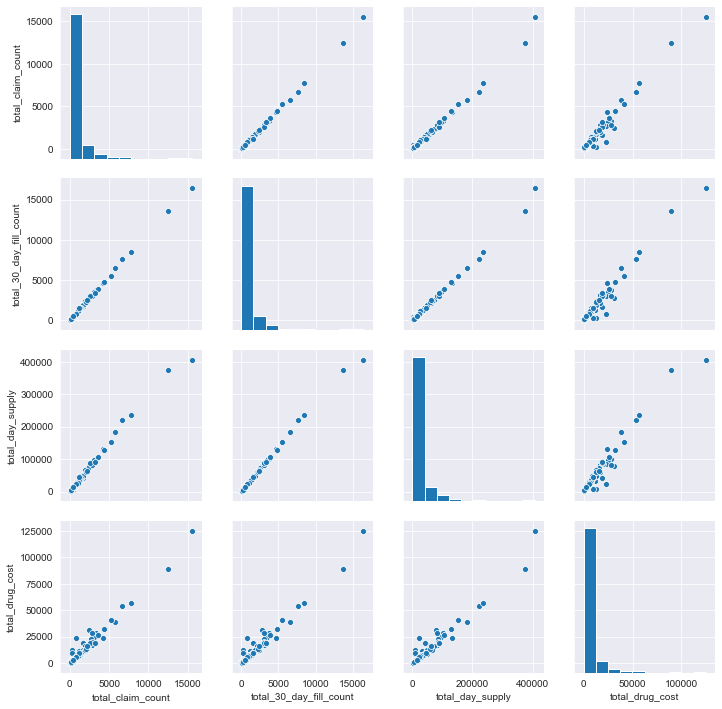

In [208]:
sns.pairplot(benzo_town_sum[benzo_town_sum['generic_name'] == 'alprazolam'])

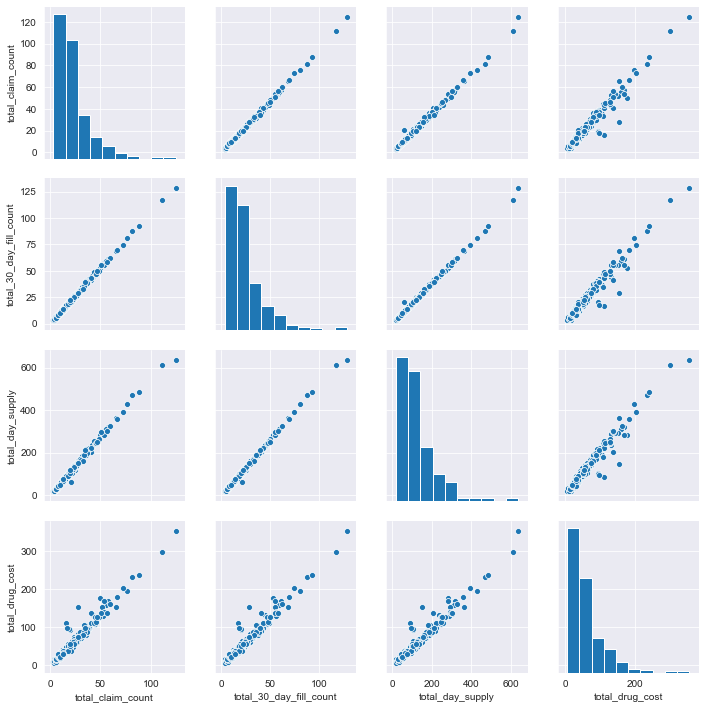

In [211]:
sns.pairplot(benzo_town_sum[benzo_town_sum['generic_name'] == 'alprazolam'].iloc[:, 2:].apply(np.sqrt))

In [215]:
benzo_town_sum_norm = benzo_town_sum.copy()
for x in list(benzo_town_sum_norm.columns)[2:]:
    benzo_town_sum_norm[x] = np.sqrt(benzo_town_sum_norm[x])
benzo_town_sum_norm.head()

,town,generic_name,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost
0,abington,alprazolam,16.583124,17.592612,91.564185,40.346127
1,abington,diazepam,9.055385,9.165151,43.680659,82.409283
2,abington,lorazepam,19.949937,21.000000,105.858396,54.652630
3,acton,alprazolam,15.329710,16.401219,80.187281,28.733604
4,acton,diazepam,13.453624,14.053469,70.978870,29.684845


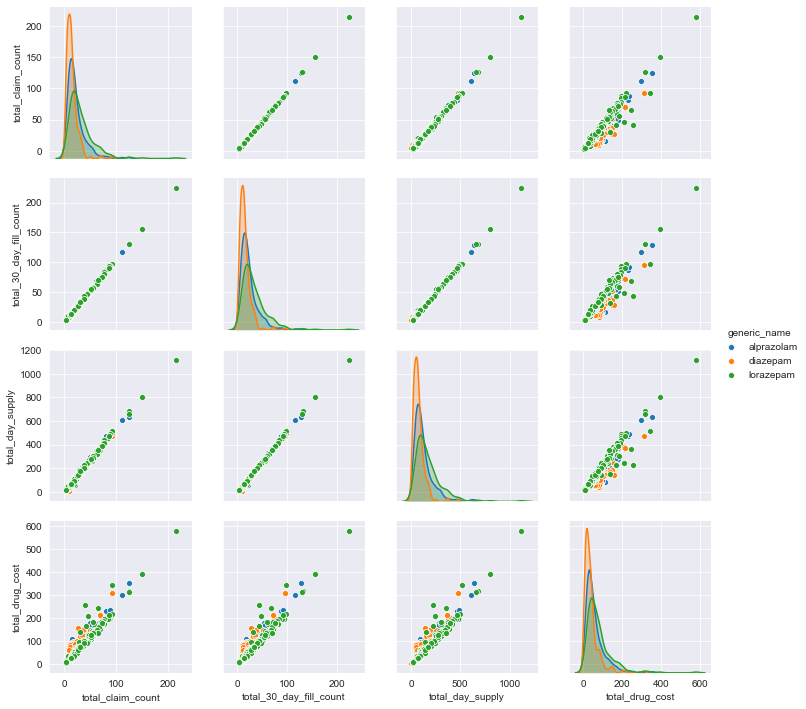

In [216]:
sns.pairplot(benzo_town_sum_norm, hue="generic_name")

## Clean older prescriber data

In [217]:
#cms_all_pres_raw = pd.read_csv("../../data/raw_data/medicare_prescription_all_drugs/PartD_Prescriber_PUF_NPI_Drug_17.txt", sep='\t')
del cms_all_pres_raw

In [218]:
cms_all_pres_16_raw =  pd.read_csv("../../data/raw_data/medicare_prescription_all_drugs/PartD_Prescriber_PUF_NPI_Drug_16.txt", sep='\t')

In [219]:
cms_all_pres_16_raw.columns

Index(['npi', 'nppes_provider_last_org_name', 'nppes_provider_first_name',
       'nppes_provider_city', 'nppes_provider_state', 'specialty_description',
       'description_flag', 'drug_name', 'generic_name', 'bene_count',
       'total_claim_count', 'total_30_day_fill_count', 'total_day_supply',
       'total_drug_cost', 'bene_count_ge65', 'bene_count_ge65_suppress_flag',
       'total_claim_count_ge65', 'ge65_suppress_flag',
       'total_30_day_fill_count_ge65', 'total_day_supply_ge65',
       'total_drug_cost_ge65'],
      dtype='object')

In [224]:
all_pres_16_MA = cms_all_pres_16_raw[cms_all_pres_16_raw['nppes_provider_state'] == 'MA']
all_pres_16_MA.head()

,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_city,nppes_provider_state,specialty_description,description_flag,drug_name,generic_name,bene_count,...,total_30_day_fill_count,total_day_supply,total_drug_cost,bene_count_ge65,bene_count_ge65_suppress_flag,total_claim_count_ge65,ge65_suppress_flag,total_30_day_fill_count_ge65,total_day_supply_ge65,total_drug_cost_ge65
713,1003002312,HOPKINS,PATRICIA,QUINCY,MA,Rheumatology,S,ACETAMINOPHEN-CODEINE,ACETAMINOPHEN WITH CODEINE,NaN,...,16.0,480,536.19,NaN,*,16.0,NaN,16.0,480.0,536.19
714,1003002312,HOPKINS,PATRICIA,QUINCY,MA,Rheumatology,S,ADVAIR DISKUS,FLUTICASONE/SALMETEROL,NaN,...,39.0,1170,13618.31,NaN,*,13.0,NaN,39.0,1170.0,13618.31
715,1003002312,HOPKINS,PATRICIA,QUINCY,MA,Rheumatology,S,ALLOPURINOL,ALLOPURINOL,14.0,...,90.8,2673,469.08,NaN,#,NaN,#,NaN,NaN,NaN
716,1003002312,HOPKINS,PATRICIA,QUINCY,MA,Rheumatology,S,ALPRAZOLAM,ALPRAZOLAM,NaN,...,25.0,750,278.12,NaN,#,NaN,#,NaN,NaN,NaN
717,1003002312,HOPKINS,PATRICIA,QUINCY,MA,Rheumatology,S,AMLODIPINE BESYLATE,AMLODIPINE BESYLATE,14.0,...,125.0,3750,421.39,NaN,#,66.0,NaN,102.0,3060.0,384.86


In [226]:
alprazolam_16_pres = all_pres_16_MA[all_pres_16_MA['generic_name'].str.lower().str.find('alprazolam') >= 0]
print(alprazolam_16_pres.shape)
display(alprazolam_16_pres['drug_name'].value_counts())
diazepam_16_pres = all_pres_16_MA[all_pres_16_MA['generic_name'].str.lower().str.find('diazepam') >= 0]
print(diazepam_16_pres.shape)
display(diazepam_16_pres['drug_name'].value_counts())
lorazepam_16_pres = all_pres_16_MA[all_pres_16_MA['generic_name'].str.lower().str.find('lorazepam') >= 0]
print(lorazepam_16_pres.shape)
display(lorazepam_16_pres['drug_name'].value_counts())

(3921, 21)


ALPRAZOLAM             3866
XANAX                    26
ALPRAZOLAM ER            22
ALPRAZOLAM ODT            3
ALPRAZOLAM XR             2
ALPRAZOLAM INTENSOL       1
XANAX XR                  1
Name: drug_name, dtype: int64

(2583, 21)


DIAZEPAM    2567
VALIUM        16
Name: drug_name, dtype: int64

(6654, 21)


LORAZEPAM             6633
LORAZEPAM INTENSOL      11
ATIVAN                  10
Name: drug_name, dtype: int64

In [227]:
benzo_pres_16 = pd.concat([alprazolam_16_pres, diazepam_16_pres, lorazepam_16_pres]).drop(['nppes_provider_city', 'nppes_provider_state'], axis=1)
display(benzo_pres_16.head())
display(benzo_pres_16.info())

,npi,nppes_provider_last_org_name,nppes_provider_first_name,specialty_description,description_flag,drug_name,generic_name,bene_count,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost,bene_count_ge65,bene_count_ge65_suppress_flag,total_claim_count_ge65,ge65_suppress_flag,total_30_day_fill_count_ge65,total_day_supply_ge65,total_drug_cost_ge65
716,1003002312,HOPKINS,PATRICIA,Rheumatology,S,ALPRAZOLAM,ALPRAZOLAM,NaN,21,25.0,750,278.12,NaN,#,NaN,#,NaN,NaN,NaN
2446,1003007477,ABDOW,KIMBERLY,Nurse Practitioner,S,ALPRAZOLAM,ALPRAZOLAM,NaN,26,30.0,876,253.86,NaN,*,NaN,*,NaN,NaN,NaN
4518,1003011610,RAY,ALAKA,Internal Medicine,S,ALPRAZOLAM,ALPRAZOLAM,NaN,14,25.0,633,34.17,NaN,*,14.0,NaN,25.0,633.0,34.17
8597,1003023284,MCELROY,ALLEGRA,Nurse Practitioner,S,ALPRAZOLAM,ALPRAZOLAM,NaN,13,13.0,370,21.10,NaN,*,NaN,*,NaN,NaN,NaN
15671,1003047473,HASSEY,SHERINE,Nurse Practitioner,S,ALPRAZOLAM,ALPRAZOLAM,11.0,16,22.0,656,76.62,NaN,#,NaN,#,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 13158 entries, 716 to 24960927
Data columns (total 19 columns):
npi                              13158 non-null int64
nppes_provider_last_org_name     13158 non-null object
nppes_provider_first_name        13158 non-null object
specialty_description            13158 non-null object
description_flag                 13158 non-null object
drug_name                        13158 non-null object
generic_name                     13158 non-null object
bene_count                       5613 non-null float64
total_claim_count                13158 non-null int64
total_30_day_fill_count          13158 non-null float64
total_day_supply                 13158 non-null int64
total_drug_cost                  13158 non-null float64
bene_count_ge65                  1826 non-null float64
bene_count_ge65_suppress_flag    11332 non-null object
total_claim_count_ge65           7275 non-null float64
ge65_suppress_flag               5883 non-null object
total_30

None

In [228]:
benzo_pres_16_sub = benzo_pres_16.dropna(axis=1).drop('description_flag', axis=1)
print(benzo_pres_16_sub.shape)
benzo_pres_16_sub.head()

(13158, 10)


,npi,nppes_provider_last_org_name,nppes_provider_first_name,specialty_description,drug_name,generic_name,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost
716,1003002312,HOPKINS,PATRICIA,Rheumatology,ALPRAZOLAM,ALPRAZOLAM,21,25.0,750,278.12
2446,1003007477,ABDOW,KIMBERLY,Nurse Practitioner,ALPRAZOLAM,ALPRAZOLAM,26,30.0,876,253.86
4518,1003011610,RAY,ALAKA,Internal Medicine,ALPRAZOLAM,ALPRAZOLAM,14,25.0,633,34.17
8597,1003023284,MCELROY,ALLEGRA,Nurse Practitioner,ALPRAZOLAM,ALPRAZOLAM,13,13.0,370,21.10
15671,1003047473,HASSEY,SHERINE,Nurse Practitioner,ALPRAZOLAM,ALPRAZOLAM,16,22.0,656,76.62


In [230]:
for x in list(benzo_pres_16_sub.columns)[1:6]:
    benzo_pres_16_sub[x] = benzo_pres_16_sub[x].str.lower()

In [234]:
opi_pres_16_npi_town_match = med_opi_pres_no_town_dup[med_opi_pres_no_town_dup['year'] == 2016][['npi', 'nppes_provider_last_name', 'nppes_provider_first_name', 'town']].copy()
print(benzo_pres_16_sub.shape)
print(opi_pres_16_npi_town_match.shape)
benzo_town_merge_16 = benzo_pres_16_sub.merge(opi_pres_16_npi_town_match, how="inner", on="npi", suffixes=["_benz", "_opi"])
print(benzo_town_merge_16.shape)
print(benzo_town_merge_16.columns)
benzo_town_merge_16.head()

(13158, 10)
(34977, 4)
(13132, 13)
Index(['npi', 'nppes_provider_last_org_name', 'nppes_provider_first_name_benz',
       'specialty_description', 'drug_name', 'generic_name',
       'total_claim_count', 'total_30_day_fill_count', 'total_day_supply',
       'total_drug_cost', 'nppes_provider_last_name',
       'nppes_provider_first_name_opi', 'town'],
      dtype='object')


,npi,nppes_provider_last_org_name,nppes_provider_first_name_benz,specialty_description,drug_name,generic_name,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost,nppes_provider_last_name,nppes_provider_first_name_opi,town
0,1003002312,hopkins,patricia,rheumatology,alprazolam,alprazolam,21,25.0,750,278.12,hopkins,patricia,quincy
1,1003002312,hopkins,patricia,rheumatology,diazepam,diazepam,19,19.0,507,89.89,hopkins,patricia,quincy
2,1003002312,hopkins,patricia,rheumatology,lorazepam,lorazepam,142,150.0,4380,782.41,hopkins,patricia,quincy
3,1003007477,abdow,kimberly,nurse practitioner,alprazolam,alprazolam,26,30.0,876,253.86,abdow,kimberly,worcester
4,1003007477,abdow,kimberly,nurse practitioner,diazepam,diazepam,25,25.0,750,121.84,abdow,kimberly,worcester


In [236]:
print(sum(benzo_town_merge_16['nppes_provider_last_org_name'] != benzo_town_merge_16['nppes_provider_last_name']))
print(sum(benzo_town_merge_16['nppes_provider_first_name_benz'] != benzo_town_merge_16['nppes_provider_first_name_opi']))
benzo_town_merge_16.drop(['nppes_provider_last_name', 'nppes_provider_first_name_opi'], axis=1, inplace=True)

0
0


In [246]:
print(benzo_town_merge_17.shape)
print(benzo_town_merge_16.shape)
display(benzo_town_merge_17.head())
display(benzo_town_merge_16.head())

(13138, 11)
(13132, 11)


,npi,nppes_provider_last_org_name,nppes_provider_first_name_benz,specialty_description,drug_name,generic_name,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost,town
0,1003002312,hopkins,patricia,rheumatology,alprazolam,alprazolam,21,25.0,735,213.58,quincy
1,1003002312,hopkins,patricia,rheumatology,diazepam,diazepam,14,14.0,360,56.56,quincy
2,1003002312,hopkins,patricia,rheumatology,lorazepam,lorazepam,129,139.0,4028,907.84,quincy
3,1003007477,abdow,kimberly,nurse practitioner,alprazolam,alprazolam,63,75.0,2160,324.14,worcester
4,1003007477,abdow,kimberly,nurse practitioner,diazepam,diazepam,97,97.6,2920,781.21,worcester


,npi,nppes_provider_last_org_name,nppes_provider_first_name_benz,specialty_description,drug_name,generic_name,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost,town
0,1003002312,hopkins,patricia,rheumatology,alprazolam,alprazolam,21,25.0,750,278.12,quincy
1,1003002312,hopkins,patricia,rheumatology,diazepam,diazepam,19,19.0,507,89.89,quincy
2,1003002312,hopkins,patricia,rheumatology,lorazepam,lorazepam,142,150.0,4380,782.41,quincy
3,1003007477,abdow,kimberly,nurse practitioner,alprazolam,alprazolam,26,30.0,876,253.86,worcester
4,1003007477,abdow,kimberly,nurse practitioner,diazepam,diazepam,25,25.0,750,121.84,worcester


In [247]:
del cms_all_pres_16_raw

In [248]:
cms_all_pres_15_raw =  pd.read_csv("../../data/raw_data/medicare_prescription_all_drugs/PartD_Prescriber_PUF_NPI_Drug_15.txt", sep='\t')

In [249]:
all_pres_15_MA = cms_all_pres_15_raw[cms_all_pres_15_raw['nppes_provider_state'] == 'MA']
alprazolam_15_pres = all_pres_15_MA[all_pres_15_MA['generic_name'].str.lower().str.find('alprazolam') >= 0]
print(alprazolam_15_pres.shape)
display(alprazolam_15_pres['drug_name'].value_counts())
diazepam_15_pres = all_pres_15_MA[all_pres_15_MA['generic_name'].str.lower().str.find('diazepam') >= 0]
print(diazepam_15_pres.shape)
display(diazepam_15_pres['drug_name'].value_counts())
lorazepam_15_pres = all_pres_15_MA[all_pres_15_MA['generic_name'].str.lower().str.find('lorazepam') >= 0]
print(lorazepam_15_pres.shape)
display(lorazepam_15_pres['drug_name'].value_counts())

(3793, 21)


ALPRAZOLAM        3741
ALPRAZOLAM ER       24
XANAX               21
ALPRAZOLAM ODT       3
ALPRAZOLAM XR        2
XANAX XR             2
Name: drug_name, dtype: int64

(2588, 21)


DIAZEPAM    2575
VALIUM        13
Name: drug_name, dtype: int64

(6463, 21)


LORAZEPAM             6419
LORAZEPAM INTENSOL      31
ATIVAN                  13
Name: drug_name, dtype: int64

In [250]:
benzo_pres_15 = pd.concat([alprazolam_15_pres, diazepam_15_pres, lorazepam_15_pres]).drop(['nppes_provider_city', 'nppes_provider_state'], axis=1)
display(benzo_pres_15.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12844 entries, 652 to 24521569
Data columns (total 19 columns):
npi                              12844 non-null int64
nppes_provider_last_org_name     12844 non-null object
nppes_provider_first_name        12844 non-null object
specialty_description            12844 non-null object
description_flag                 12844 non-null object
drug_name                        12844 non-null object
generic_name                     12844 non-null object
bene_count                       5267 non-null float64
total_claim_count                12844 non-null int64
total_30_day_fill_count          12844 non-null float64
total_day_supply                 12844 non-null int64
total_drug_cost                  12844 non-null float64
bene_count_ge65                  1809 non-null float64
bene_count_ge65_suppress_flag    11035 non-null object
total_claim_count_ge65           7110 non-null float64
ge65_suppress_flag               5734 non-null object
total_30

None

In [251]:
benzo_pres_15_sub = benzo_pres_15.dropna(axis=1).drop('description_flag', axis=1)
print(benzo_pres_15_sub.shape)
benzo_pres_15_sub.head()

(12844, 10)


,npi,nppes_provider_last_org_name,nppes_provider_first_name,specialty_description,drug_name,generic_name,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost
652,1003002312,HOPKINS,PATRICIA,Internal Medicine,ALPRAZOLAM,ALPRAZOLAM,26,32.0,960,263.50
14460,1003044272,BENDER,ELISE,Family Practice,ALPRAZOLAM,ALPRAZOLAM,15,19.0,439,51.41
19502,1003062647,BEAUZILE,RONALD,Internal Medicine,ALPRAZOLAM,ALPRAZOLAM,16,16.0,452,241.53
43176,1003164310,SIMPSON,SOMATRA,Nurse Practitioner,ALPRAZOLAM,ALPRAZOLAM,184,184.0,5450,1092.11
50083,1003218041,LYONS,PATRICK,Nurse Practitioner,ALPRAZOLAM,ALPRAZOLAM,16,16.0,418,60.67


In [252]:
for x in list(benzo_pres_15_sub.columns)[1:6]:
    benzo_pres_15_sub[x] = benzo_pres_15_sub[x].str.lower()

In [253]:
opi_pres_15_npi_town_match = med_opi_pres_no_town_dup[med_opi_pres_no_town_dup['year'] == 2015][['npi', 'nppes_provider_last_name', 'nppes_provider_first_name', 'town']].copy()
print(benzo_pres_15_sub.shape)
print(opi_pres_15_npi_town_match.shape)
benzo_town_merge_15 = benzo_pres_15_sub.merge(opi_pres_15_npi_town_match, how="inner", on="npi", suffixes=["_benz", "_opi"])
print(benzo_town_merge_15.shape)
print(benzo_town_merge_15.columns)
benzo_town_merge_15.head()

(12844, 10)
(34026, 4)
(12820, 13)
Index(['npi', 'nppes_provider_last_org_name', 'nppes_provider_first_name_benz',
       'specialty_description', 'drug_name', 'generic_name',
       'total_claim_count', 'total_30_day_fill_count', 'total_day_supply',
       'total_drug_cost', 'nppes_provider_last_name',
       'nppes_provider_first_name_opi', 'town'],
      dtype='object')


,npi,nppes_provider_last_org_name,nppes_provider_first_name_benz,specialty_description,drug_name,generic_name,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost,nppes_provider_last_name,nppes_provider_first_name_opi,town
0,1003002312,hopkins,patricia,internal medicine,alprazolam,alprazolam,26,32.0,960,263.50,hopkins,patricia,quincy
1,1003002312,hopkins,patricia,internal medicine,diazepam,diazepam,17,17.0,501,65.54,hopkins,patricia,quincy
2,1003002312,hopkins,patricia,internal medicine,lorazepam,lorazepam,122,132.0,3773,707.43,hopkins,patricia,quincy
3,1003044272,bender,elise,family practice,alprazolam,alprazolam,15,19.0,439,51.41,bender,elise,braintree
4,1003044272,bender,elise,family practice,lorazepam,lorazepam,17,21.0,538,43.52,bender,elise,braintree


In [255]:
print(sum(benzo_town_merge_15['nppes_provider_last_org_name'] != benzo_town_merge_15['nppes_provider_last_name']))
print(sum(benzo_town_merge_15['nppes_provider_first_name_benz'] != benzo_town_merge_15['nppes_provider_first_name_opi']))
benzo_town_merge_15.drop(['nppes_provider_last_name', 'nppes_provider_first_name_opi'], axis=1, inplace=True)

0
0


In [256]:
print(benzo_town_merge_17.shape)
print(benzo_town_merge_16.shape)
print(benzo_town_merge_15.shape)

(13138, 11)
(13132, 11)
(12820, 11)


In [257]:
del cms_all_pres_15_raw

In [258]:
cms_all_pres_14_raw =  pd.read_csv("../../data/raw_data/medicare_prescription_all_drugs/PartD_Prescriber_PUF_NPI_Drug_14.txt", sep='\t')

In [259]:
all_pres_14_MA = cms_all_pres_14_raw[cms_all_pres_14_raw['nppes_provider_state'] == 'MA']
alprazolam_14_pres = all_pres_14_MA[all_pres_14_MA['generic_name'].str.lower().str.find('alprazolam') >= 0]
print(alprazolam_14_pres.shape)
display(alprazolam_14_pres['drug_name'].value_counts())
diazepam_14_pres = all_pres_14_MA[all_pres_14_MA['generic_name'].str.lower().str.find('diazepam') >= 0]
print(diazepam_14_pres.shape)
display(diazepam_14_pres['drug_name'].value_counts())
lorazepam_14_pres = all_pres_14_MA[all_pres_14_MA['generic_name'].str.lower().str.find('lorazepam') >= 0]
print(lorazepam_14_pres.shape)
display(lorazepam_14_pres['drug_name'].value_counts())

(3760, 21)


ALPRAZOLAM             3708
ALPRAZOLAM ER            24
XANAX                    19
ALPRAZOLAM XR             4
ALPRAZOLAM ODT            3
ALPRAZOLAM INTENSOL       1
XANAX XR                  1
Name: drug_name, dtype: int64

(2591, 21)


DIAZEPAM           2580
VALIUM               10
DIASTAT ACUDIAL       1
Name: drug_name, dtype: int64

(6293, 21)


LORAZEPAM             6274
ATIVAN                  10
LORAZEPAM INTENSOL       9
Name: drug_name, dtype: int64

In [260]:
benzo_pres_14 = pd.concat([alprazolam_14_pres, diazepam_14_pres, lorazepam_14_pres]).drop(['nppes_provider_city', 'nppes_provider_state'], axis=1)
display(benzo_pres_14.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12644 entries, 610 to 24117229
Data columns (total 19 columns):
npi                              12644 non-null int64
nppes_provider_last_org_name     12644 non-null object
nppes_provider_first_name        12644 non-null object
specialty_description            12644 non-null object
description_flag                 12644 non-null object
drug_name                        12644 non-null object
generic_name                     12644 non-null object
bene_count                       5009 non-null float64
total_claim_count                12644 non-null int64
total_30_day_fill_count          12644 non-null float64
total_day_supply                 12644 non-null int64
total_drug_cost                  12644 non-null float64
bene_count_ge65                  1746 non-null float64
bene_count_ge65_suppress_flag    10898 non-null object
total_claim_count_ge65           6850 non-null float64
ge65_suppress_flag               5794 non-null object
total_30

None

In [261]:
benzo_pres_14_sub = benzo_pres_14.dropna(axis=1).drop('description_flag', axis=1)
print(benzo_pres_14_sub.shape)
benzo_pres_14_sub.head()

(12644, 10)


,npi,nppes_provider_last_org_name,nppes_provider_first_name,specialty_description,drug_name,generic_name,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost
610,1003002312,HOPKINS,PATRICIA,Internal Medicine,ALPRAZOLAM,ALPRAZOLAM,22,28.0,840,191.83
8082,1003023284,MCELROY,ALLEGRA,Nurse Practitioner,ALPRAZOLAM,ALPRAZOLAM,11,11.0,320,58.73
18800,1003062647,BEAUZILE,RONALD,Internal Medicine,ALPRAZOLAM,ALPRAZOLAM,16,16.0,448,116.43
25590,1003086976,KHERA,VANDANA,Internal Medicine,ALPRAZOLAM,ALPRAZOLAM,22,22.0,514,82.94
39132,1003164310,SIMPSON,SOMATRA,Nurse Practitioner,ALPRAZOLAM,ALPRAZOLAM,82,83.5,2348,462.21


In [262]:
for x in list(benzo_pres_14_sub.columns)[1:6]:
    benzo_pres_14_sub[x] = benzo_pres_14_sub[x].str.lower()

In [263]:
opi_pres_14_npi_town_match = med_opi_pres_no_town_dup[med_opi_pres_no_town_dup['year'] == 2014][['npi', 'nppes_provider_last_name', 'nppes_provider_first_name', 'town']].copy()
print(benzo_pres_14_sub.shape)
print(opi_pres_14_npi_town_match.shape)
benzo_town_merge_14 = benzo_pres_14_sub.merge(opi_pres_14_npi_town_match, how="inner", on="npi", suffixes=["_benz", "_opi"])
print(benzo_town_merge_14.shape)
print(benzo_town_merge_14.columns)
benzo_town_merge_14.head()

(12644, 10)
(33329, 4)
(12621, 13)
Index(['npi', 'nppes_provider_last_org_name', 'nppes_provider_first_name_benz',
       'specialty_description', 'drug_name', 'generic_name',
       'total_claim_count', 'total_30_day_fill_count', 'total_day_supply',
       'total_drug_cost', 'nppes_provider_last_name',
       'nppes_provider_first_name_opi', 'town'],
      dtype='object')


,npi,nppes_provider_last_org_name,nppes_provider_first_name_benz,specialty_description,drug_name,generic_name,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost,nppes_provider_last_name,nppes_provider_first_name_opi,town
0,1003002312,hopkins,patricia,internal medicine,alprazolam,alprazolam,22,28.0,840,191.83,hopkins,patricia,quincy
1,1003002312,hopkins,patricia,internal medicine,diazepam,diazepam,26,26.0,755,166.64,hopkins,patricia,quincy
2,1003002312,hopkins,patricia,internal medicine,lorazepam,lorazepam,107,114.0,3393,676.93,hopkins,patricia,quincy
3,1003023284,mcelroy,allegra,nurse practitioner,alprazolam,alprazolam,11,11.0,320,58.73,mcelroy,allegra,mashpee
4,1003023284,mcelroy,allegra,nurse practitioner,diazepam,diazepam,17,17.0,481,55.05,mcelroy,allegra,mashpee


In [265]:
print(sum(benzo_town_merge_14['nppes_provider_last_org_name'] != benzo_town_merge_14['nppes_provider_last_name']))
print(sum(benzo_town_merge_14['nppes_provider_first_name_benz'] != benzo_town_merge_14['nppes_provider_first_name_opi']))
benzo_town_merge_14.drop(['nppes_provider_last_name', 'nppes_provider_first_name_opi'], axis=1, inplace=True)

0
0


In [266]:
print(benzo_town_merge_17.shape)
print(benzo_town_merge_16.shape)
print(benzo_town_merge_15.shape)
print(benzo_town_merge_14.shape)

(13138, 11)
(13132, 11)
(12820, 11)
(12621, 11)


In [267]:
del cms_all_pres_14_raw

In [268]:
cms_all_pres_13_raw =  pd.read_csv("../../data/raw_data/medicare_prescription_all_drugs/PartD_Prescriber_PUF_NPI_Drug_13.txt", sep='\t')

In [269]:
all_pres_13_MA = cms_all_pres_13_raw[cms_all_pres_13_raw['nppes_provider_state'] == 'MA']
alprazolam_13_pres = all_pres_13_MA[all_pres_13_MA['generic_name'].str.lower().str.find('alprazolam') >= 0]
print(alprazolam_13_pres.shape)
display(alprazolam_13_pres['drug_name'].value_counts())
diazepam_13_pres = all_pres_13_MA[all_pres_13_MA['generic_name'].str.lower().str.find('diazepam') >= 0]
print(diazepam_13_pres.shape)
display(diazepam_13_pres['drug_name'].value_counts())
lorazepam_13_pres = all_pres_13_MA[all_pres_13_MA['generic_name'].str.lower().str.find('lorazepam') >= 0]
print(lorazepam_13_pres.shape)
display(lorazepam_13_pres['drug_name'].value_counts())

(3558, 21)


ALPRAZOLAM             3509
ALPRAZOLAM ER            26
XANAX                    14
ALPRAZOLAM XR             4
ALPRAZOLAM INTENSOL       2
ALPRAZOLAM ODT            2
XANAX XR                  1
Name: drug_name, dtype: int64

(2537, 21)


DIAZEPAM    2529
VALIUM         8
Name: drug_name, dtype: int64

(6088, 21)


LORAZEPAM             6069
LORAZEPAM INTENSOL      12
ATIVAN                   7
Name: drug_name, dtype: int64

In [270]:
benzo_pres_13 = pd.concat([alprazolam_13_pres, diazepam_13_pres, lorazepam_13_pres]).drop(['nppes_provider_city', 'nppes_provider_state'], axis=1)
display(benzo_pres_13.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12183 entries, 551 to 23642799
Data columns (total 19 columns):
npi                              12183 non-null int64
nppes_provider_last_org_name     12183 non-null object
nppes_provider_first_name        12183 non-null object
specialty_description            12183 non-null object
description_flag                 12183 non-null object
drug_name                        12183 non-null object
generic_name                     12183 non-null object
bene_count                       4763 non-null float64
total_claim_count                12183 non-null int64
total_30_day_fill_count          12183 non-null float64
total_day_supply                 12183 non-null int64
total_drug_cost                  12183 non-null float64
bene_count_ge65                  1696 non-null float64
bene_count_ge65_suppress_flag    10487 non-null object
total_claim_count_ge65           6628 non-null float64
ge65_suppress_flag               5555 non-null object
total_30

None

In [271]:
benzo_pres_13_sub = benzo_pres_13.dropna(axis=1).drop('description_flag', axis=1)
print(benzo_pres_13_sub.shape)
benzo_pres_13_sub.head()

(12183, 10)


,npi,nppes_provider_last_org_name,nppes_provider_first_name,specialty_description,drug_name,generic_name,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost
551,1003002312,HOPKINS,PATRICIA,Internal Medicine,ALPRAZOLAM,ALPRAZOLAM,29,35.0,947,183.70
9410,1003030586,KSHEERSAGAR,PANKAJ,Family Practice,ALPRAZOLAM,ALPRAZOLAM,15,15.0,450,59.09
12142,1003042441,MANZO,MARK,Physician Assistant,ALPRAZOLAM,ALPRAZOLAM,17,17.0,500,77.42
17125,1003062647,BEAUZILE,RONALD,Internal Medicine,ALPRAZOLAM,ALPRAZOLAM,18,18.0,481,113.03
23373,1003086976,KHERA,VANDANA,Internal Medicine,ALPRAZOLAM,ALPRAZOLAM,17,17.0,495,72.85


In [272]:
for x in list(benzo_pres_13_sub.columns)[1:6]:
    benzo_pres_13_sub[x] = benzo_pres_13_sub[x].str.lower()

In [273]:
opi_pres_13_npi_town_match = med_opi_pres_no_town_dup[med_opi_pres_no_town_dup['year'] == 2013][['npi', 'nppes_provider_last_name', 'nppes_provider_first_name', 'town']].copy()
print(benzo_pres_13_sub.shape)
print(opi_pres_13_npi_town_match.shape)
benzo_town_merge_13 = benzo_pres_13_sub.merge(opi_pres_13_npi_town_match, how="inner", on="npi", suffixes=["_benz", "_opi"])
print(benzo_town_merge_13.shape)
print(benzo_town_merge_13.columns)
benzo_town_merge_13.head()

(12183, 10)
(32734, 4)
(12162, 13)
Index(['npi', 'nppes_provider_last_org_name', 'nppes_provider_first_name_benz',
       'specialty_description', 'drug_name', 'generic_name',
       'total_claim_count', 'total_30_day_fill_count', 'total_day_supply',
       'total_drug_cost', 'nppes_provider_last_name',
       'nppes_provider_first_name_opi', 'town'],
      dtype='object')


,npi,nppes_provider_last_org_name,nppes_provider_first_name_benz,specialty_description,drug_name,generic_name,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost,nppes_provider_last_name,nppes_provider_first_name_opi,town
0,1003002312,hopkins,patricia,internal medicine,alprazolam,alprazolam,29,35.0,947,183.70,hopkins,patricia,quincy
1,1003002312,hopkins,patricia,internal medicine,diazepam,diazepam,16,16.0,460,86.53,hopkins,patricia,quincy
2,1003002312,hopkins,patricia,internal medicine,lorazepam,lorazepam,72,87.0,2496,510.97,hopkins,patricia,quincy
3,1003030586,ksheersagar,pankaj,family practice,alprazolam,alprazolam,15,15.0,450,59.09,ksheersagar,pankaj,worcester
4,1003042441,manzo,mark,physician assistant,alprazolam,alprazolam,17,17.0,500,77.42,manzo,mark,grafton


In [274]:
print(sum(benzo_town_merge_13['nppes_provider_last_org_name'] != benzo_town_merge_13['nppes_provider_last_name']))
print(sum(benzo_town_merge_13['nppes_provider_first_name_benz'] != benzo_town_merge_13['nppes_provider_first_name_opi']))
benzo_town_merge_13.drop(['nppes_provider_last_name', 'nppes_provider_first_name_opi'], axis=1, inplace=True)

0
0


In [275]:
print(benzo_town_merge_17.shape)
print(benzo_town_merge_16.shape)
print(benzo_town_merge_15.shape)
print(benzo_town_merge_14.shape)
print(benzo_town_merge_13.shape)

(13138, 11)
(13132, 11)
(12820, 11)
(12621, 11)
(12162, 11)


In [276]:
benzo_town_merge_17['year'] = 2017
benzo_town_merge_16['year'] = 2016
benzo_town_merge_15['year'] = 2015
benzo_town_merge_14['year'] = 2014
benzo_town_merge_13['year'] = 2013

In [287]:
benzo_pres_town_all = pd.concat([benzo_town_merge_17, benzo_town_merge_16, benzo_town_merge_15, benzo_town_merge_14, benzo_town_merge_13])
print(benzo_pres_town_all.shape)
display(benzo_pres_town_all.head())
sum(benzo_pres_town_all[['npi', 'year']].drop_duplicates()['npi'].value_counts() > 5)

(63873, 12)


,npi,nppes_provider_last_org_name,nppes_provider_first_name_benz,specialty_description,drug_name,generic_name,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost,town,year
0,1003002312,hopkins,patricia,rheumatology,alprazolam,alprazolam,21,25.0,735,213.58,quincy,2017
1,1003002312,hopkins,patricia,rheumatology,diazepam,diazepam,14,14.0,360,56.56,quincy,2017
2,1003002312,hopkins,patricia,rheumatology,lorazepam,lorazepam,129,139.0,4028,907.84,quincy,2017
3,1003007477,abdow,kimberly,nurse practitioner,alprazolam,alprazolam,63,75.0,2160,324.14,worcester,2017
4,1003007477,abdow,kimberly,nurse practitioner,diazepam,diazepam,97,97.6,2920,781.21,worcester,2017


0

In [288]:
#benzo_pres_town_all.to_csv("../../data/tidy_data/med_partD_benzo_indiv_pres_w_town_merge_13_to_17.csv", index=False)

In [290]:
benzo_town_year_sum = benzo_pres_town_all.groupby(['town', 'generic_name', 'year']).sum().reset_index().drop('npi', axis=1)
print(benzo_town_year_sum.shape)
benzo_town_year_sum.head()

(3653, 7)


,town,generic_name,year,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost
0,abington,alprazolam,2013,457,495.0,13567,3185.74
1,abington,alprazolam,2014,413,442.8,12428,2427.40
2,abington,alprazolam,2015,385,410.0,11241,2234.07
3,abington,alprazolam,2016,284,316.5,8777,1534.62
4,abington,alprazolam,2017,275,309.5,8384,1627.81


In [291]:
#benzo_town_year_sum.to_csv("../../data/tidy_data/med_partD_benzo_sum_w_town_merge_13_to_17.csv", index=False)

# Older code

In [ ]:
print(np.logical_and.reduce(cms_pres_sum_13.columns == cms_pres_sum_14.columns))
print(np.logical_and.reduce(cms_pres_sum_14.columns == cms_pres_sum_15.columns))
print(np.logical_and.reduce(cms_pres_sum_15.columns == cms_pres_sum_16.columns))
print(np.logical_and.reduce(cms_pres_sum_16.columns == cms_pres_sum_17.columns))

In [ ]:
# zipcode check - for some reason the zipcodes imported as floats intstead of integers
# look for any num after decimal point
zip_tail_13 =[x[1:] for x in cms_pres_sum_13['NPPES Provider ZIP Code'].astype(str).str.split('.')]
zip_tail_13_flat = [y for x in zip_tail_13 for y in x]
print([x for x in zip_tail_13_flat if x != '0'])


zip_tail_14 =[x[1:] for x in cms_pres_sum_14['NPPES Provider ZIP Code'].astype(str).str.split('.')]
zip_tail_14_flat = [y for x in zip_tail_14 for y in x]
print([x for x in zip_tail_14_flat if x != '0'])

zip_tail_15 =[x[1:] for x in cms_pres_sum_15['NPPES Provider ZIP Code'].astype(str).str.split('.')]
zip_tail_15_flat = [y for x in zip_tail_15 for y in x]
print([x for x in zip_tail_15_flat if x != '0'])


zip_tail_16 =[x[1:] for x in cms_pres_sum_16['NPPES Provider ZIP Code'].astype(str).str.split('.')]
zip_tail_16_flat = [y for x in zip_tail_16 for y in x]
print([x for x in zip_tail_16_flat if x != '0'])

zip_tail_17 =[x[1:] for x in cms_pres_sum_17['NPPES Provider ZIP Code'].astype(str).str.split('.')]
zip_tail_17_flat = [y for x in zip_tail_17 for y in x]
print([x for x in zip_tail_17_flat if x != '0'])

In [ ]:
cms_pres_13_NE = cms_pres_sum_13[cms_pres_sum_13['NPPES Provider State'].isin(['MA', 'NY', 'CT', 'RI', 'NH', 'ME', 'VT'])]
cms_pres_14_NE = cms_pres_sum_14[cms_pres_sum_14['NPPES Provider State'].isin(['MA', 'NY', 'CT', 'RI', 'NH', 'ME', 'VT'])]
cms_pres_15_NE = cms_pres_sum_15[cms_pres_sum_15['NPPES Provider State'].isin(['MA', 'NY', 'CT', 'RI', 'NH', 'ME', 'VT'])]
cms_pres_16_NE = cms_pres_sum_16[cms_pres_sum_16['NPPES Provider State'].isin(['MA', 'NY', 'CT', 'RI', 'NH', 'ME', 'VT'])]
cms_pres_17_NE = cms_pres_sum_17[cms_pres_sum_17['NPPES Provider State'].isin(['MA', 'NY', 'CT', 'RI', 'NH', 'ME', 'VT'])]

In [ ]:
cms_13_MA = cms_pres_13_NE[cms_pres_13_NE['nppes_provider_state'] == 'MA'].copy()
cms_14_MA = cms_pres_14_NE[cms_pres_14_NE['nppes_provider_state'] == 'MA'].copy()
cms_15_MA = cms_pres_15_NE[cms_pres_15_NE['nppes_provider_state'] == 'MA'].copy()
cms_16_MA = cms_pres_16_NE[cms_pres_16_NE['nppes_provider_state'] == 'MA'].copy()
cms_17_MA = cms_pres_17_NE[cms_pres_17_NE['nppes_provider_state'] == 'MA'].copy()

In [ ]:
cms_13_MA.head()

In [ ]:
cms_MA_13_14 = cms_13_MA.merge(cms_14_MA, how='inner', on='npi', suffixes=('_13', '_14'))
cms_MA_15_16 = cms_15_MA.merge(cms_16_MA, how='inner', on='npi', suffixes=('_13', '_14'))

In [ ]:
cms_13_MA['year'] = [2013] * len(cms_13_MA.index)
cms_14_MA['year'] = [2014] * len(cms_14_MA.index)
cms_15_MA['year'] = [2015] * len(cms_15_MA.index)
cms_16_MA['year'] = [2016] * len(cms_16_MA.index)
cms_17_MA['year'] = [2017] * len(cms_17_MA.index)

In [ ]:
cms_13_MA.head()

In [ ]:
cms_MA = pd.concat([cms_13_MA, cms_14_MA, cms_15_MA, cms_16_MA, cms_17_MA], axis = 0)

In [ ]:
cms_MA.head()

In [ ]:
cms_year_zip_sum = cms_MA.groupby(['nppes_provider_zip_code', 'year']).mean()[['opioid_prescribing_rate', 'long-acting_opioid_prescribing_rate']]

In [ ]:
cms_year_zip_sum.sort_values('opioid_prescribing_rate', ascending=False)

In [ ]:
cms_MA.describe()

In [ ]:
cms_all_pres_raw.head()

In [ ]:
cms_all_pres_MA = cms_all_pres_raw[cms_all_pres_raw['npi'].isin(set(cms_MA['npi']))].copy()

In [ ]:
cms_all_pres_MA.head()

In [ ]:
len(set(cms_all_pres_MA['nppes_provider_city']))

In [ ]:
cms_all_MA_info = cms_all_pres_MA.iloc[:, 0:5].drop_duplicates().copy()

In [ ]:
cms_all_MA_info[cms_all_MA_info['nppes_provider_state'] != 'MA']

In [ ]:
test = cms_all_pres_raw[cms_all_pres_raw['npi'].isin(set(cms_17_MA['npi']))].copy()

In [ ]:
test.head()

In [ ]:
test2 = test.iloc[:, 0:5].drop_duplicates().copy()

In [ ]:
test2[test2['nppes_provider_state'] != 'MA']